In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [83]:
SEQ_LEN = 30
BATCH_SIZE = 64
HIDDEN_DIM = 64
NUM_LAYERS_SIMPLE = 1
NUM_LAYERS_DEEP = 3
NUM_EPOCHS = 30
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
df = pd.read_csv("data/SHEL_data.csv")

In [6]:

feature_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
values = df[feature_cols].astype(np.float32).values
n_samples, n_features = values.shape


In [7]:
split_idx = int(0.9 * n_samples)

In [8]:
scaler = StandardScaler()
values_train = values[:split_idx]
scaler.fit(values_train)
values_scaled = scaler.transform(values).astype(np.float32)

In [9]:
def make_sequences(values_scaled, seq_len, split_idx):
    X_train, y_train = [], []
    X_test, y_test = [], []

    ## training sequences: target index t in [seq_len, split_idx-1]
    for t in range(seq_len, split_idx):
        X_train.append(values_scaled[t-seq_len:t])
        y_train.append(values_scaled[t])

    ## test sequences: target index t in [split_idx, n_samples-1]
    n_total = values_scaled.shape[0]
    for t in range(split_idx, n_total):
        if t - seq_len < 0:
            continue
        X_test.append(values_scaled[t-seq_len:t])
        y_test.append(values_scaled[t])

    X_train = np.stack(X_train) ## [N_train, T, D]
    y_train = np.stack(y_train) ## [N_train, D]
    X_test = np.stack(X_test) ## [N_test, T, D]
    y_test = np.stack(y_test) ## [N_test, D]

    return X_train, y_train, X_test, y_test


In [10]:

X_train, y_train, X_test, y_test = make_sequences(values_scaled, SEQ_LEN, split_idx)

In [11]:
print("Train sequences:", X_train.shape, "Test sequences:", X_test.shape)

Train sequences: (849, 30, 6) Test sequences: (98, 30, 6)


In [12]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X) ## [N, T, D]
        self.y = torch.from_numpy(y) ## [N, D]

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
train_ds = TimeSeriesDataset(X_train, y_train)
test_ds = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
df_gen = pd.read_csv("data/XOM_data.csv")

In [27]:


values_gen = df_gen[feature_cols].astype(np.float32).values
n_samples_gen, n_features_gen = values_gen.shape


In [28]:
scaler = StandardScaler()
values_train_gen = values_gen[:split_idx]
scaler.fit(values_train_gen)
values_scaled_gen = scaler.transform(values_gen).astype(np.float32)

In [38]:
split_idx_gen = SEQ_LEN + 1

In [39]:

X_train_gen, y_train_gen, X_test_gen, y_test_gen = make_sequences(values_scaled_gen, SEQ_LEN, split_idx_gen)

In [40]:
print("Train sequences:", X_train_gen.shape, "Test sequences:", X_test_gen.shape)

Train sequences: (1, 30, 6) Test sequences: (946, 30, 6)


In [41]:
train_ds_gen = TimeSeriesDataset(X_train_gen, y_train_gen)
test_ds_gen = TimeSeriesDataset(X_test_gen, y_test_gen)

train_loader_gen = DataLoader(train_ds_gen, batch_size=BATCH_SIZE, shuffle=True)
test_loader_gen = DataLoader(test_ds_gen, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
class RNNForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,
                 rnn_type="LSTM", num_layers=1):
        super().__init__()
        if rnn_type == "RNN":
            self.rnn = nn.RNN(
                input_dim, hidden_dim, num_layers=num_layers,
                batch_first=True
            )
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(
                input_dim, hidden_dim, num_layers=num_layers,
                batch_first=True
            )
        elif rnn_type == "LSTM":
            self.rnn = nn.LSTM(
                input_dim, hidden_dim, num_layers=num_layers,
                batch_first=True
            )
        else:
            raise ValueError("rnn_type must be 'RNN', 'GRU', or 'LSTM'")
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        ## x: [B, T, D]
        out, _ = self.rnn(x) ## out: [B, T, H]
        last_hidden = out[:, -1] ## [B, H]
        pred = self.fc(last_hidden) ## [B, D]
        return pred


In [15]:
def make_model(model_name="Simple LSTM"):
    if "RNN" in model_name and "Simple" in model_name:
        return RNNForecaster(n_features, HIDDEN_DIM, n_features,
                             rnn_type="RNN", num_layers=NUM_LAYERS_SIMPLE)
    if "RNN" in model_name and "Deep" in model_name:
        return RNNForecaster(n_features, HIDDEN_DIM, n_features,
                             rnn_type="RNN", num_layers=NUM_LAYERS_DEEP)
    if "GRU" in model_name and "Simple" in model_name:
        return RNNForecaster(n_features, HIDDEN_DIM, n_features,
                             rnn_type="GRU", num_layers=NUM_LAYERS_SIMPLE)
    if "GRU" in model_name and "Deep" in model_name:
        return RNNForecaster(n_features, HIDDEN_DIM, n_features,
                             rnn_type="GRU", num_layers=NUM_LAYERS_DEEP)
    if "LSTM" in model_name and "Simple" in model_name:
        return RNNForecaster(n_features, HIDDEN_DIM, n_features,
                             rnn_type="LSTM", num_layers=NUM_LAYERS_SIMPLE)
    if "LSTM" in model_name and "Deep" in model_name:
        return RNNForecaster(n_features, HIDDEN_DIM, n_features,
                             rnn_type="LSTM", num_layers=NUM_LAYERS_DEEP)
    ## default
    return RNNForecaster(n_features, HIDDEN_DIM, n_features,
                         rnn_type="LSTM", num_layers=NUM_LAYERS_SIMPLE)

In [16]:
def train_model(model_name="Simple LSTM"):
    model = make_model(model_name).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)

        train_loss /= len(train_ds)
        if epoch % 5 == 0 or epoch == 1:
            print(f"[{model_name}] Epoch {epoch}/{NUM_EPOCHS}, "
                  f"Train MSE (scaled): {train_loss:.4f}")

    return model

In [17]:
def compute_metrics(y_true_scaled, y_pred_scaled, X_test_scaled_last):
    """
    y_true_scaled: [N, D]
    y_pred_scaled: [N, D]
    X_test_scaled_last: [N, D]  (last input of each window, scaled)
    """
    ## Scaled RMSE
    mse_scaled = np.mean((y_pred_scaled - y_true_scaled) ** 2)
    rmse_scaled = np.sqrt(mse_scaled)

    ## MAPE (on original scale)
    y_true = scaler.inverse_transform(y_true_scaled)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    eps = 1e-6
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100.0

    ## Mean Directional Accuracy (direction of change from last input to target)
    ## use scaled values (sign preserved)
    last = X_test_scaled_last
    actual_change = np.sign(y_true_scaled - last)
    pred_change = np.sign(y_pred_scaled - last)
    correct_dir = (actual_change == pred_change).astype(np.float32)
    mda = correct_dir.mean()

    ## R^2 (on scaled)
    r2 = r2_score(
        y_true_scaled.reshape(-1),
        y_pred_scaled.reshape(-1)
    )

    ## Forecast bias (on original)
    bias_per_feature = np.mean(y_pred - y_true, axis=0)  # [D]
    bias_overall = bias_per_feature.mean()
    ## classify: over / under / none
    avg_abs_level = np.mean(np.abs(y_true))
    threshold = 0.01 * avg_abs_level  ## 1% of average magnitude
    if abs(bias_overall) < threshold:
        bias_flag = "None / minimal"
    elif bias_overall > 0:
        bias_flag = "Over-forecast (too high)"
    else:
        bias_flag = "Under-forecast (too low)"

    metrics = {
        "Scaled_RMSE": float(rmse_scaled),
        "MAPE_percent": float(mape),
        "MDA": float(mda),
        "R2": float(r2),
        "Bias_overall": float(bias_overall),
        "Bias_flag": bias_flag,
        "Bias_per_feature": dict(zip(feature_cols, bias_per_feature))
    }
    return metrics

**SIMPLE LSTM**

In [18]:
model_name = "Simple LSTM" ## change to "Deep LSTM", "Simple GRU", etc.
model = train_model(model_name)


[Simple LSTM] Epoch 1/30, Train MSE (scaled): 0.8352
[Simple LSTM] Epoch 5/30, Train MSE (scaled): 0.1725
[Simple LSTM] Epoch 10/30, Train MSE (scaled): 0.1490
[Simple LSTM] Epoch 15/30, Train MSE (scaled): 0.1431
[Simple LSTM] Epoch 20/30, Train MSE (scaled): 0.1425
[Simple LSTM] Epoch 25/30, Train MSE (scaled): 0.1377
[Simple LSTM] Epoch 30/30, Train MSE (scaled): 0.1387


In [19]:
model.eval()
all_preds_scaled = []
all_true_scaled = []
all_last_inputs_scaled = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model(xb)

        all_preds_scaled.append(preds.cpu().numpy())
        all_true_scaled.append(yb.cpu().numpy())
        all_last_inputs_scaled.append(xb[:, -1, :].cpu().numpy())

In [20]:
y_pred_scaled = np.concatenate(all_preds_scaled, axis=0) ## [N_test, D]
y_true_scaled = np.concatenate(all_true_scaled, axis=0) ## [N_test, D]
X_last_scaled = np.concatenate(all_last_inputs_scaled, axis=0) ## [N_test, D]

In [21]:
metrics = compute_metrics(y_true_scaled, y_pred_scaled, X_last_scaled)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Simple LSTM ===
Scaled_RMSE : 0.4279719591140747
MAPE_percent : 6.396503925323486
MDA : 0.5289115905761719
R2 : 0.7863471508026123
Bias_overall : 9183.5498046875
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: 0.4977
  High: 0.1333
  Low: 0.2009
  Close: 0.3041
  Adj Close: -0.5510
  Volume: 55100.7109


In [22]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Simple LSTM', 'Scaled RMSE': 0.4279719591140747, 'MAPE': 6.396503925323486, 'Mean Directional Accuracy (MDA)': 0.5289115905761719, 'R^2': 0.7863471508026123, 'Forecast Bias?': 'Over-forecast (too high)'}


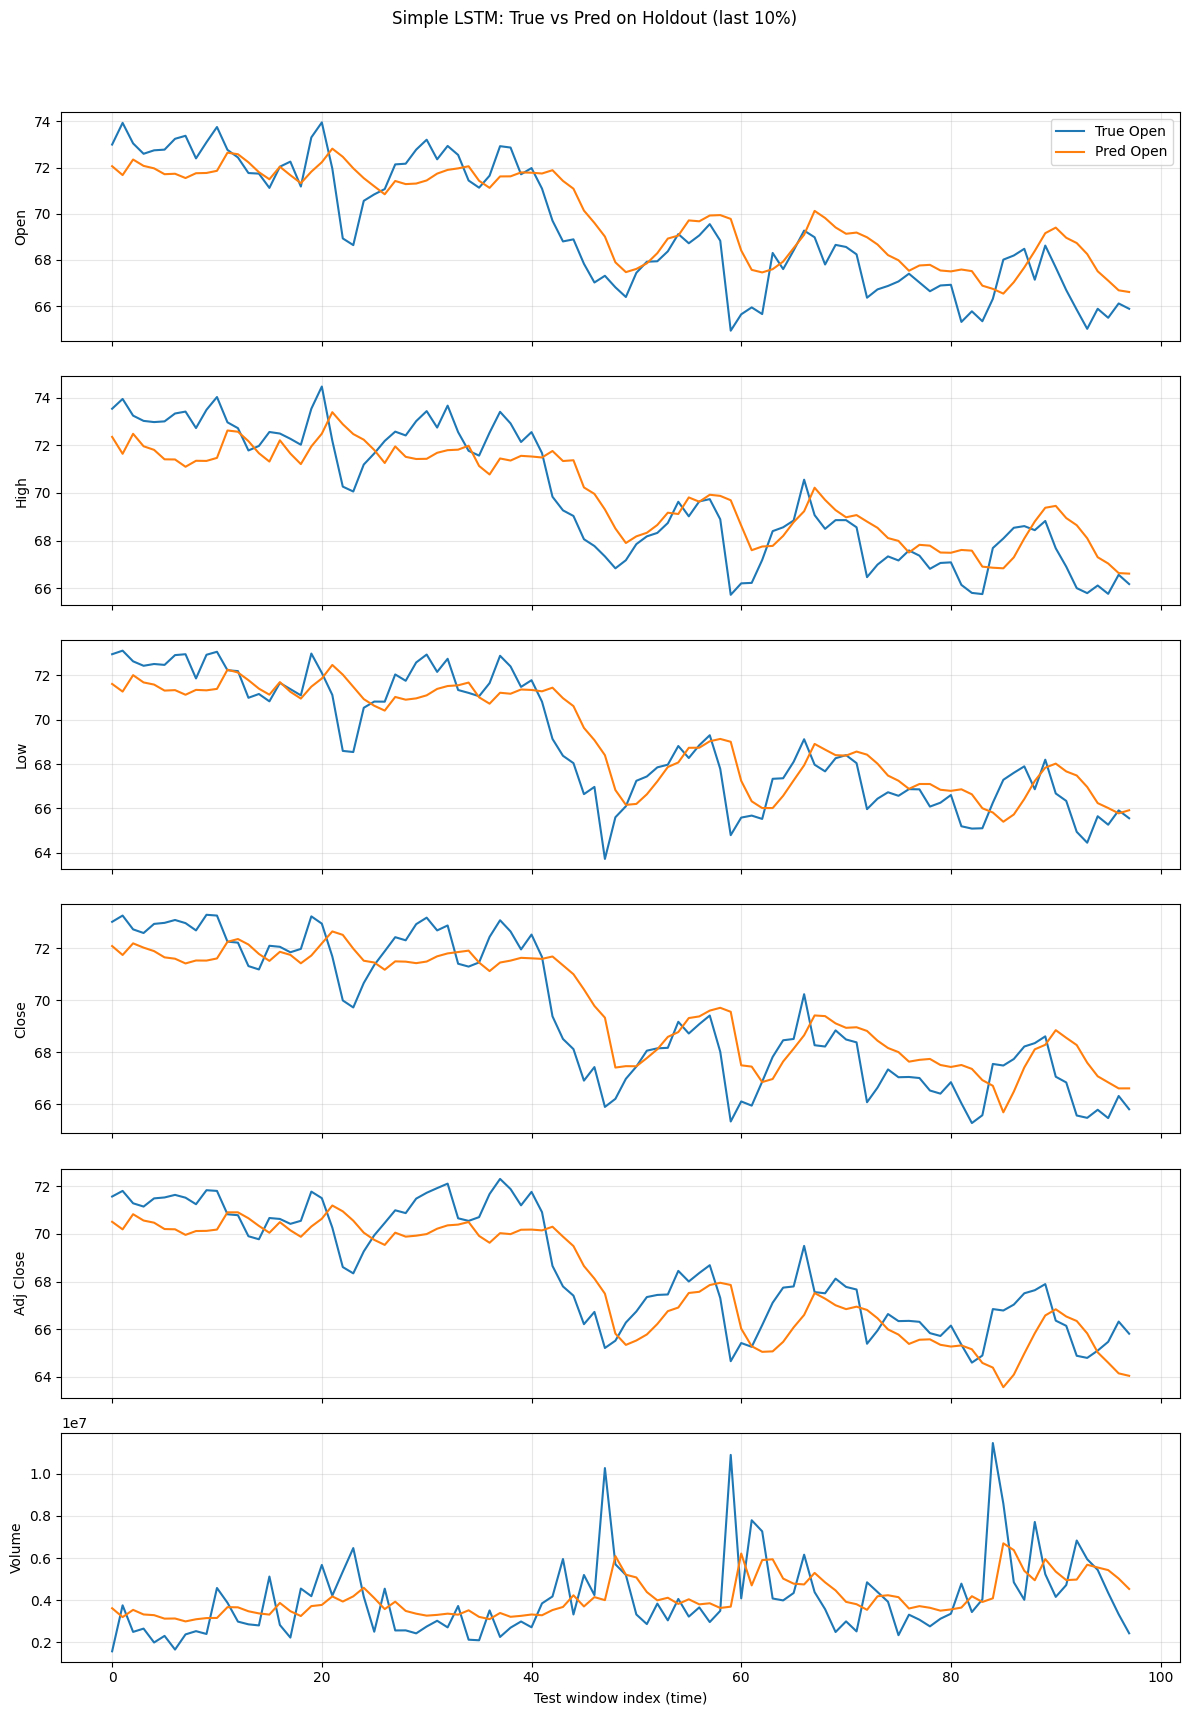

In [23]:
y_true = scaler.inverse_transform(y_true_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

n_test = y_true.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name}: True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Generalizability Test

In [42]:
model.eval()
all_preds_scaled_gen = []
all_true_scaled_gen = []
all_last_inputs_scaled_gen = []

with torch.no_grad():
    for xb, yb in test_loader_gen:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds_gen = model(xb)

        all_preds_scaled_gen.append(preds_gen.cpu().numpy())
        all_true_scaled_gen.append(yb.cpu().numpy())
        all_last_inputs_scaled_gen.append(xb[:, -1, :].cpu().numpy())

In [44]:
y_pred_scaled_gen = np.concatenate(all_preds_scaled_gen, axis=0) ## [N_test, D]
y_true_scaled_gen = np.concatenate(all_true_scaled_gen, axis=0) ## [N_test, D]
X_last_scaled_gen = np.concatenate(all_last_inputs_scaled_gen, axis=0) ## [N_test, D]

In [45]:
metrics = compute_metrics(y_true_scaled_gen, y_pred_scaled_gen, X_last_scaled_gen)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Simple LSTM ===
Scaled_RMSE : 0.3136121928691864
MAPE_percent : 5.114072799682617
MDA : 0.5468639731407166
R2 : 0.8981477618217468
Bias_overall : 22390.537109375
Bias_flag : None / minimal
Bias_per_feature :
  Open: 0.4356
  High: 0.1592
  Low: 0.0714
  Close: 0.5037
  Adj Close: 0.3145
  Volume: 134341.7344


In [46]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Simple LSTM', 'Scaled RMSE': 0.3136121928691864, 'MAPE': 5.114072799682617, 'Mean Directional Accuracy (MDA)': 0.5468639731407166, 'R^2': 0.8981477618217468, 'Forecast Bias?': 'None / minimal'}


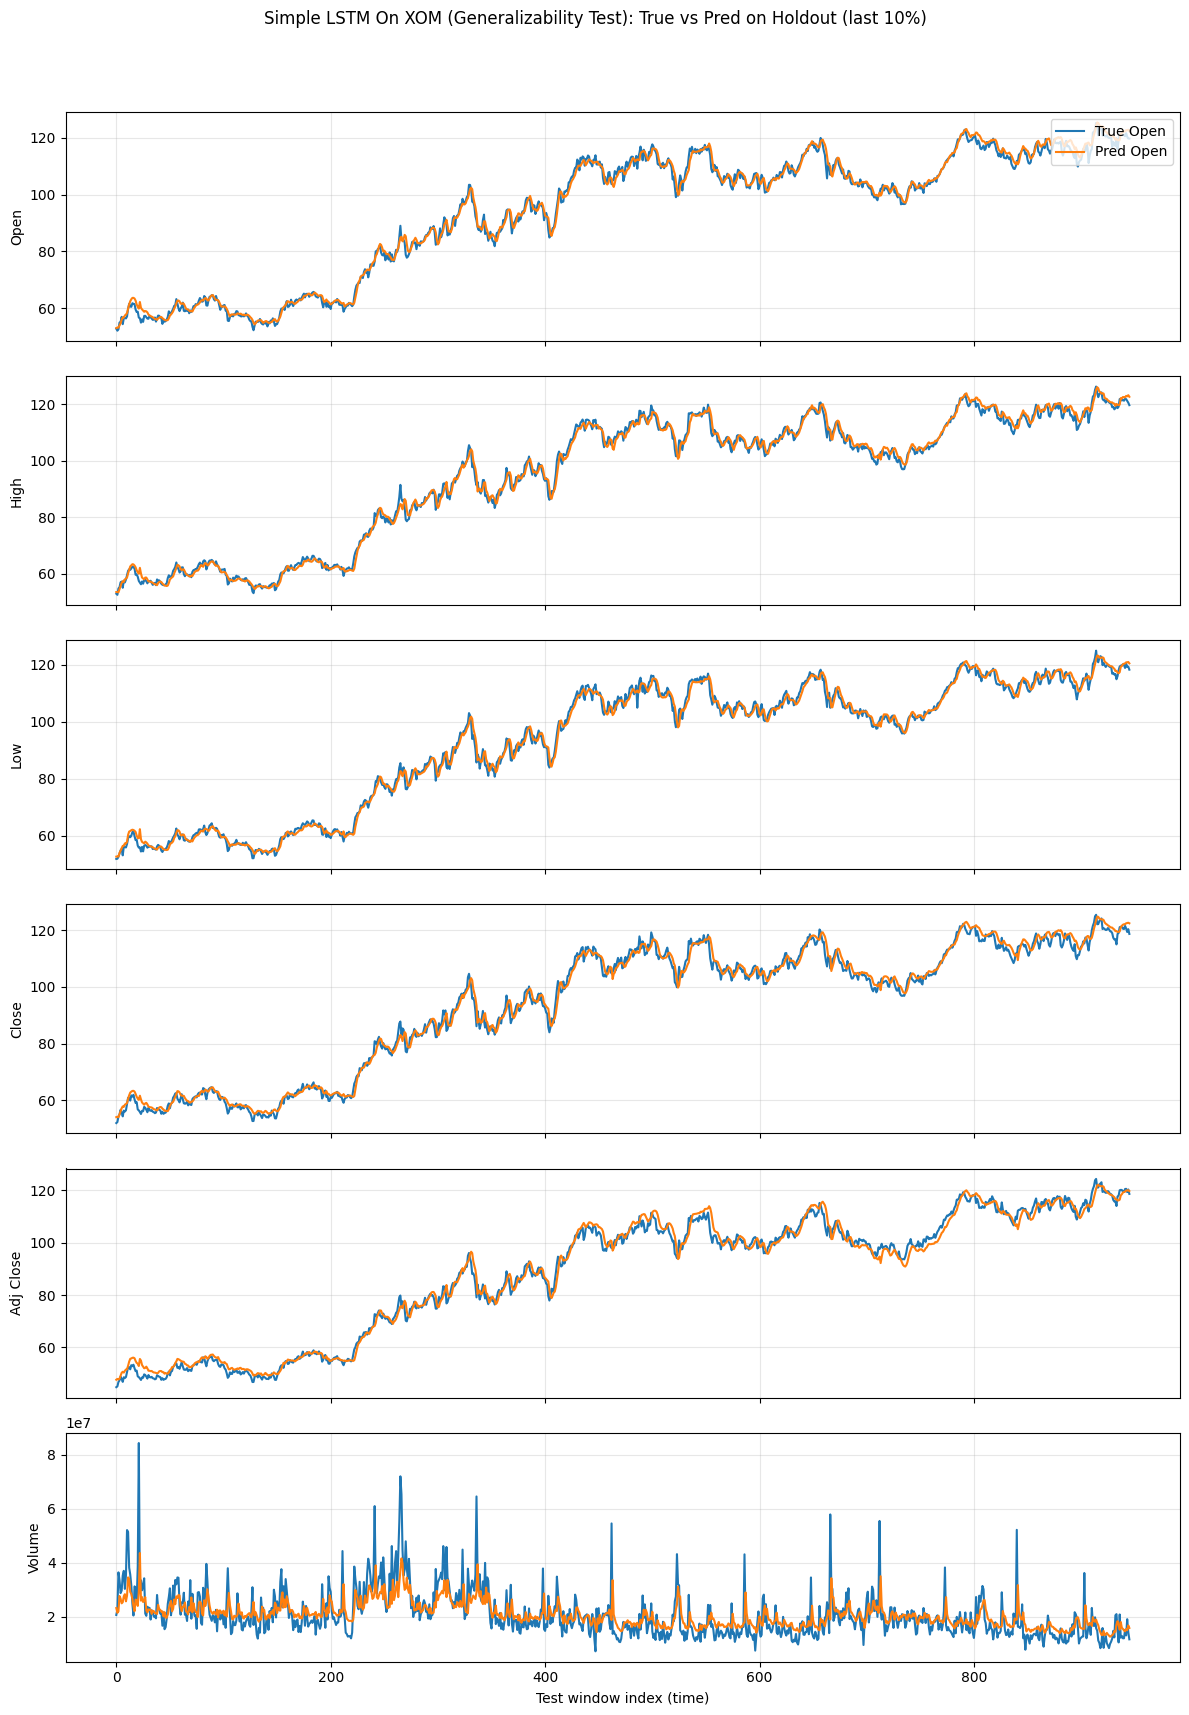

In [47]:
y_true_gen = scaler.inverse_transform(y_true_scaled_gen)
y_pred_gen = scaler.inverse_transform(y_pred_scaled_gen)

n_test = y_true_gen.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true_gen[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred_gen[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name} On XOM (Generalizability Test): True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**DEEP LSTM**

In [49]:
model_name = "Deep LSTM"
model = train_model(model_name)


[Deep LSTM] Epoch 1/30, Train MSE (scaled): 0.9055
[Deep LSTM] Epoch 5/30, Train MSE (scaled): 0.1911
[Deep LSTM] Epoch 10/30, Train MSE (scaled): 0.1795
[Deep LSTM] Epoch 15/30, Train MSE (scaled): 0.1689
[Deep LSTM] Epoch 20/30, Train MSE (scaled): 0.1622
[Deep LSTM] Epoch 25/30, Train MSE (scaled): 0.1559
[Deep LSTM] Epoch 30/30, Train MSE (scaled): 0.1487


In [50]:
model.eval()
all_preds_scaled = []
all_true_scaled = []
all_last_inputs_scaled = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model(xb)

        all_preds_scaled.append(preds.cpu().numpy())
        all_true_scaled.append(yb.cpu().numpy())
        all_last_inputs_scaled.append(xb[:, -1, :].cpu().numpy())

In [51]:
y_pred_scaled = np.concatenate(all_preds_scaled, axis=0)
y_true_scaled = np.concatenate(all_true_scaled, axis=0)
X_last_scaled = np.concatenate(all_last_inputs_scaled, axis=0)

In [52]:
metrics = compute_metrics(y_true_scaled, y_pred_scaled, X_last_scaled)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Deep LSTM ===
Scaled_RMSE : 0.4467466175556183
MAPE_percent : 10.794371604919434
MDA : 0.5340136289596558
R2 : 0.7671905159950256
Bias_overall : 409212.46875
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: -0.0102
  High: -0.3489
  Low: -0.2499
  Close: -0.4394
  Adj Close: -2.4182
  Volume: 2455278.2500


In [53]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Deep LSTM', 'Scaled RMSE': 0.4467466175556183, 'MAPE': 10.794371604919434, 'Mean Directional Accuracy (MDA)': 0.5340136289596558, 'R^2': 0.7671905159950256, 'Forecast Bias?': 'Over-forecast (too high)'}


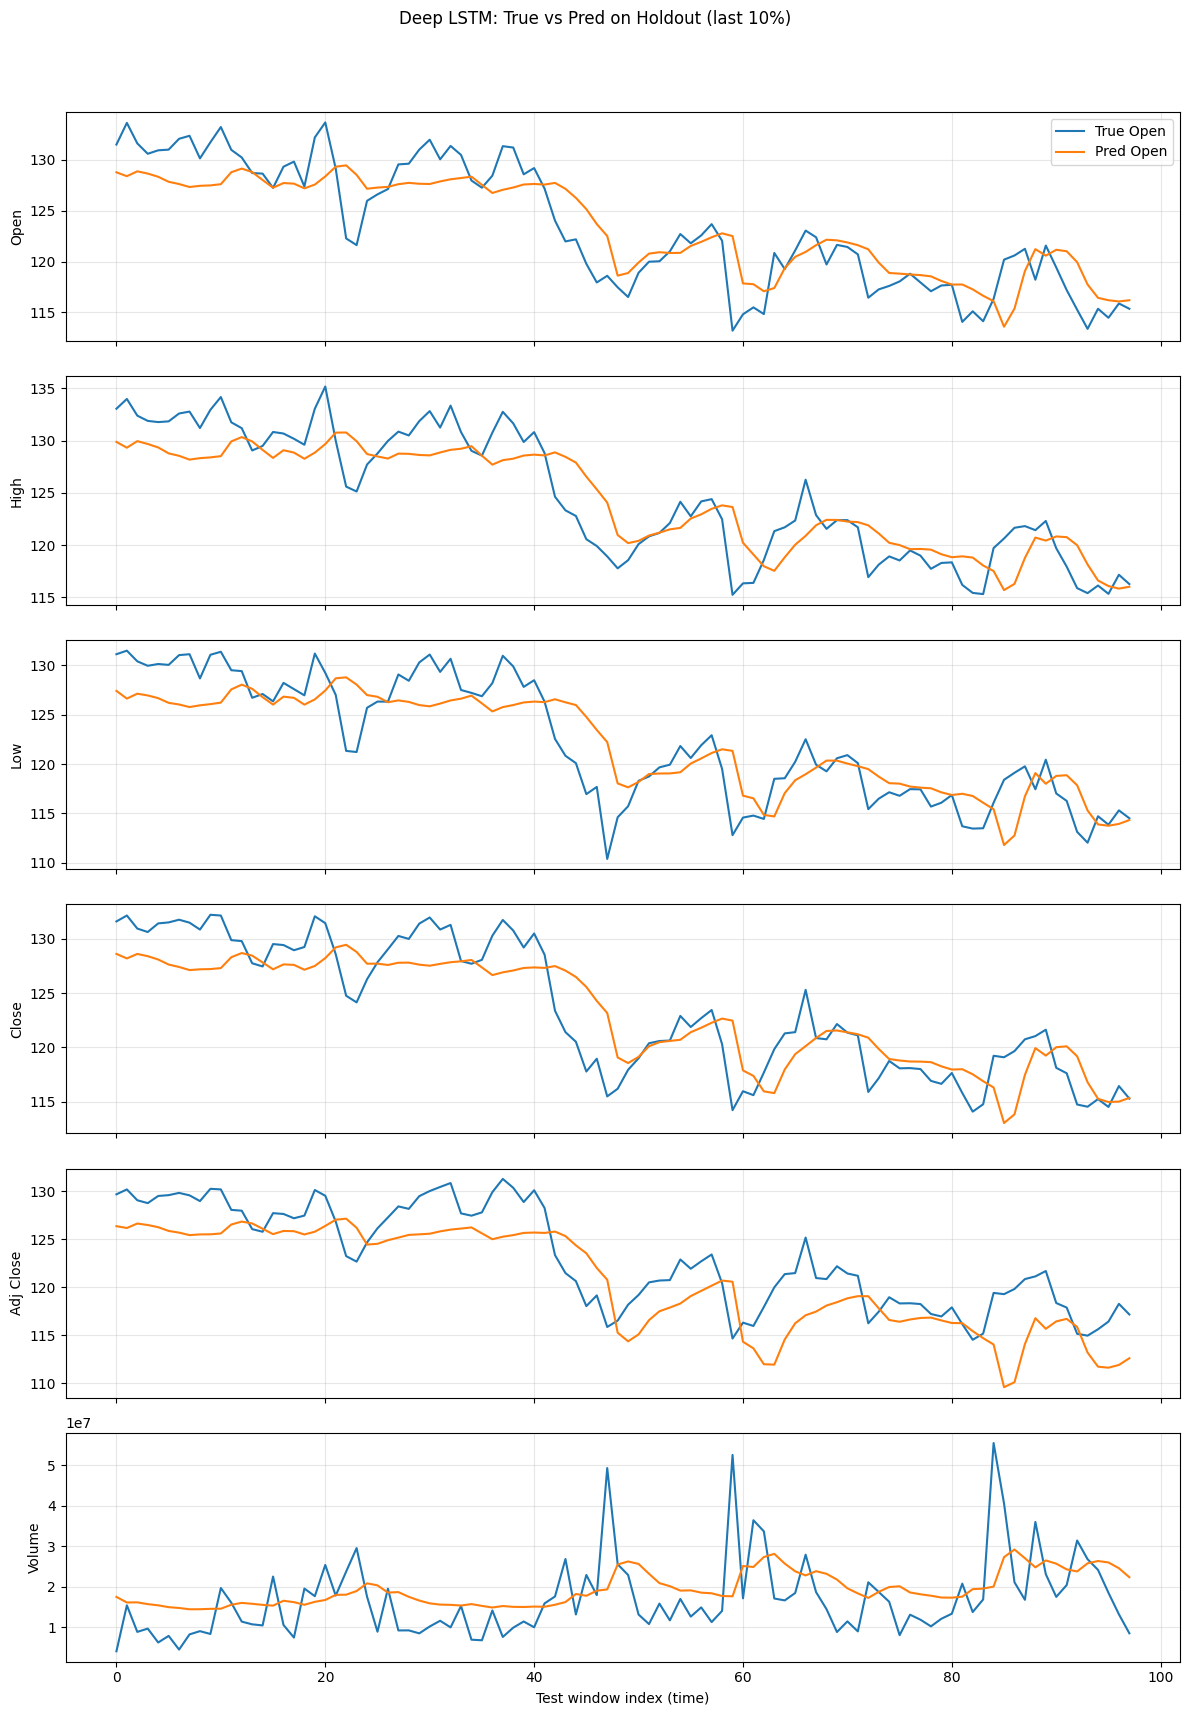

In [54]:
y_true = scaler.inverse_transform(y_true_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

n_test = y_true.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name}: True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Generalizability Test

In [55]:
model.eval()
all_preds_scaled_gen = []
all_true_scaled_gen = []
all_last_inputs_scaled_gen = []

with torch.no_grad():
    for xb, yb in test_loader_gen:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds_gen = model(xb)

        all_preds_scaled_gen.append(preds_gen.cpu().numpy())
        all_true_scaled_gen.append(yb.cpu().numpy())
        all_last_inputs_scaled_gen.append(xb[:, -1, :].cpu().numpy())

In [56]:
y_pred_scaled_gen = np.concatenate(all_preds_scaled_gen, axis=0) ## [N_test, D]
y_true_scaled_gen = np.concatenate(all_true_scaled_gen, axis=0) ## [N_test, D]
X_last_scaled_gen = np.concatenate(all_last_inputs_scaled_gen, axis=0) ## [N_test, D]

In [57]:
metrics = compute_metrics(y_true_scaled_gen, y_pred_scaled_gen, X_last_scaled_gen)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Deep LSTM ===
Scaled_RMSE : 0.3496161997318268
MAPE_percent : 6.660999298095703
MDA : 0.5082804560661316
R2 : 0.8734192252159119
Bias_overall : 226592.5
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: -1.0653
  High: -0.9963
  Low: -0.9800
  Close: -1.1652
  Adj Close: -0.9262
  Volume: 1359560.1250


In [58]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Deep LSTM', 'Scaled RMSE': 0.3496161997318268, 'MAPE': 6.660999298095703, 'Mean Directional Accuracy (MDA)': 0.5082804560661316, 'R^2': 0.8734192252159119, 'Forecast Bias?': 'Over-forecast (too high)'}


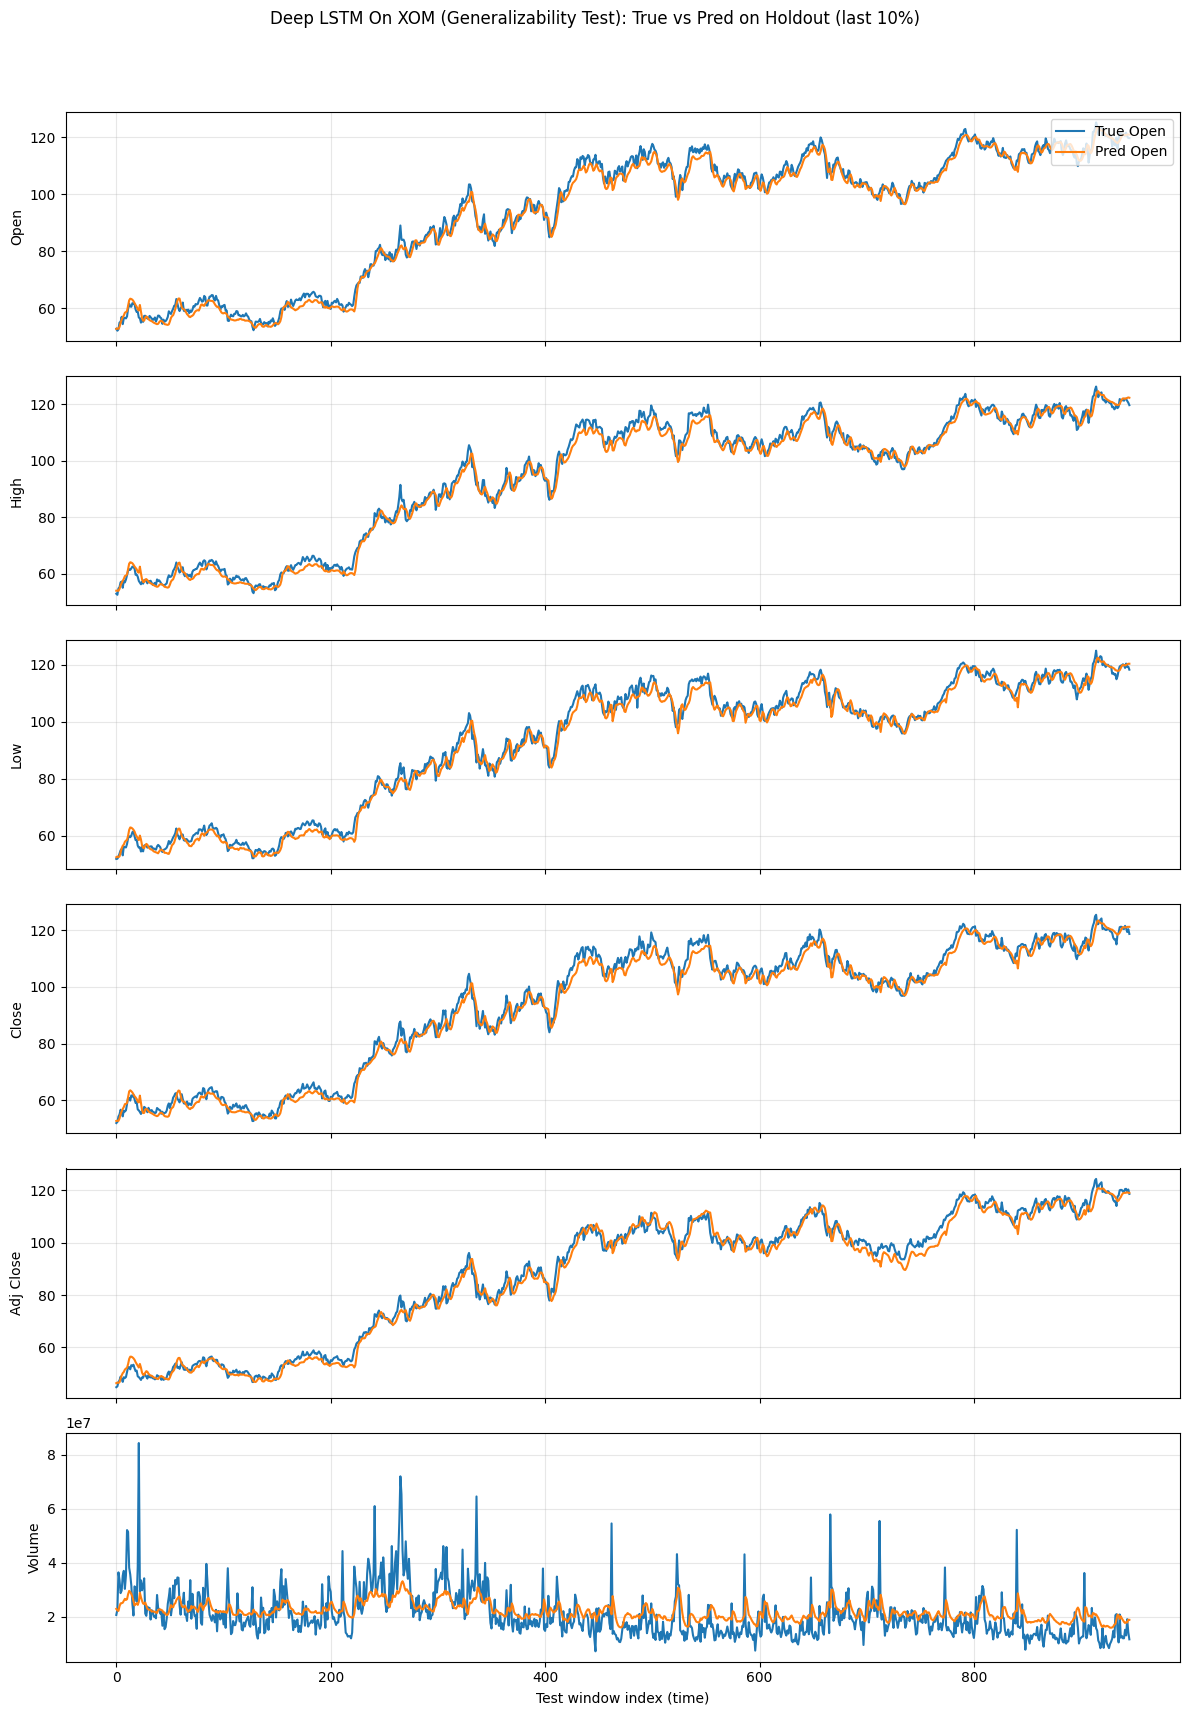

In [59]:
y_true_gen = scaler.inverse_transform(y_true_scaled_gen)
y_pred_gen = scaler.inverse_transform(y_pred_scaled_gen)

n_test = y_true_gen.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true_gen[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred_gen[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name} On XOM (Generalizability Test): True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**SIMPLE RNN**

In [60]:
model_name = "Simple RNN"
model = train_model(model_name)


[Simple RNN] Epoch 1/30, Train MSE (scaled): 0.5719
[Simple RNN] Epoch 5/30, Train MSE (scaled): 0.1531
[Simple RNN] Epoch 10/30, Train MSE (scaled): 0.1409
[Simple RNN] Epoch 15/30, Train MSE (scaled): 0.1395
[Simple RNN] Epoch 20/30, Train MSE (scaled): 0.1376
[Simple RNN] Epoch 25/30, Train MSE (scaled): 0.1364
[Simple RNN] Epoch 30/30, Train MSE (scaled): 0.1357


In [61]:
model.eval()
all_preds_scaled = []
all_true_scaled = []
all_last_inputs_scaled = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model(xb)

        all_preds_scaled.append(preds.cpu().numpy())
        all_true_scaled.append(yb.cpu().numpy())
        all_last_inputs_scaled.append(xb[:, -1, :].cpu().numpy())

In [62]:
y_pred_scaled = np.concatenate(all_preds_scaled, axis=0)
y_true_scaled = np.concatenate(all_true_scaled, axis=0)
X_last_scaled = np.concatenate(all_last_inputs_scaled, axis=0)

In [63]:
metrics = compute_metrics(y_true_scaled, y_pred_scaled, X_last_scaled)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Simple RNN ===
Scaled_RMSE : 0.4245680272579193
MAPE_percent : 9.15903377532959
MDA : 0.5391156673431396
R2 : 0.7897322177886963
Bias_overall : 202619.3125
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: 0.7321
  High: 1.1038
  Low: 1.1491
  Close: 0.9986
  Adj Close: -2.2594
  Volume: 1215714.1250


In [64]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Simple RNN', 'Scaled RMSE': 0.4245680272579193, 'MAPE': 9.15903377532959, 'Mean Directional Accuracy (MDA)': 0.5391156673431396, 'R^2': 0.7897322177886963, 'Forecast Bias?': 'Over-forecast (too high)'}


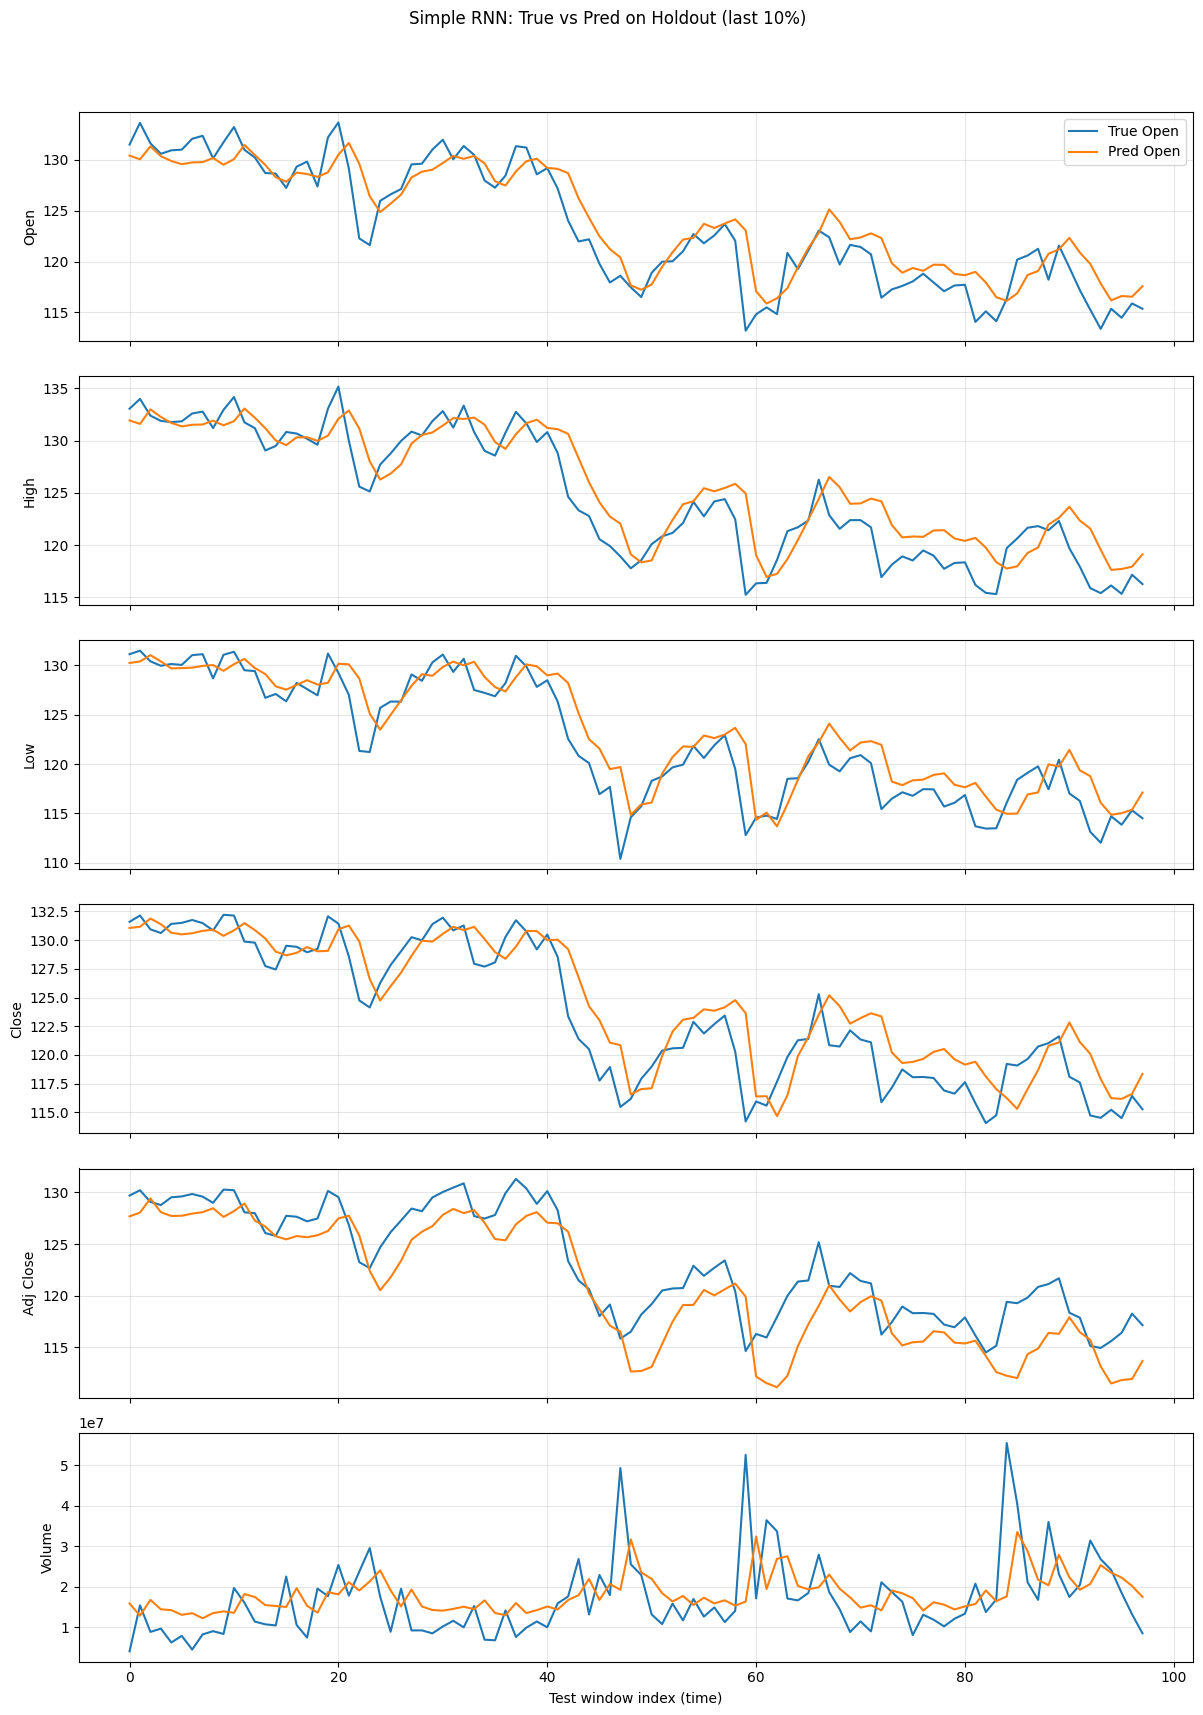

In [65]:
y_true = scaler.inverse_transform(y_true_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

n_test = y_true.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name}: True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Generalizability Test

In [66]:
model.eval()
all_preds_scaled_gen = []
all_true_scaled_gen = []
all_last_inputs_scaled_gen = []

with torch.no_grad():
    for xb, yb in test_loader_gen:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds_gen = model(xb)

        all_preds_scaled_gen.append(preds_gen.cpu().numpy())
        all_true_scaled_gen.append(yb.cpu().numpy())
        all_last_inputs_scaled_gen.append(xb[:, -1, :].cpu().numpy())

In [67]:
y_pred_scaled_gen = np.concatenate(all_preds_scaled_gen, axis=0) ## [N_test, D]
y_true_scaled_gen = np.concatenate(all_true_scaled_gen, axis=0) ## [N_test, D]
X_last_scaled_gen = np.concatenate(all_last_inputs_scaled_gen, axis=0) ## [N_test, D]

In [68]:
metrics = compute_metrics(y_true_scaled_gen, y_pred_scaled_gen, X_last_scaled_gen)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Simple RNN ===
Scaled_RMSE : 0.31136777997016907
MAPE_percent : 5.023614883422852
MDA : 0.5634249448776245
R2 : 0.8996003866195679
Bias_overall : 59850.83984375
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: 0.3187
  High: 0.3568
  Low: 0.3404
  Close: 0.3499
  Adj Close: 0.0992
  Volume: 359103.5625


In [69]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Simple RNN', 'Scaled RMSE': 0.31136777997016907, 'MAPE': 5.023614883422852, 'Mean Directional Accuracy (MDA)': 0.5634249448776245, 'R^2': 0.8996003866195679, 'Forecast Bias?': 'Over-forecast (too high)'}


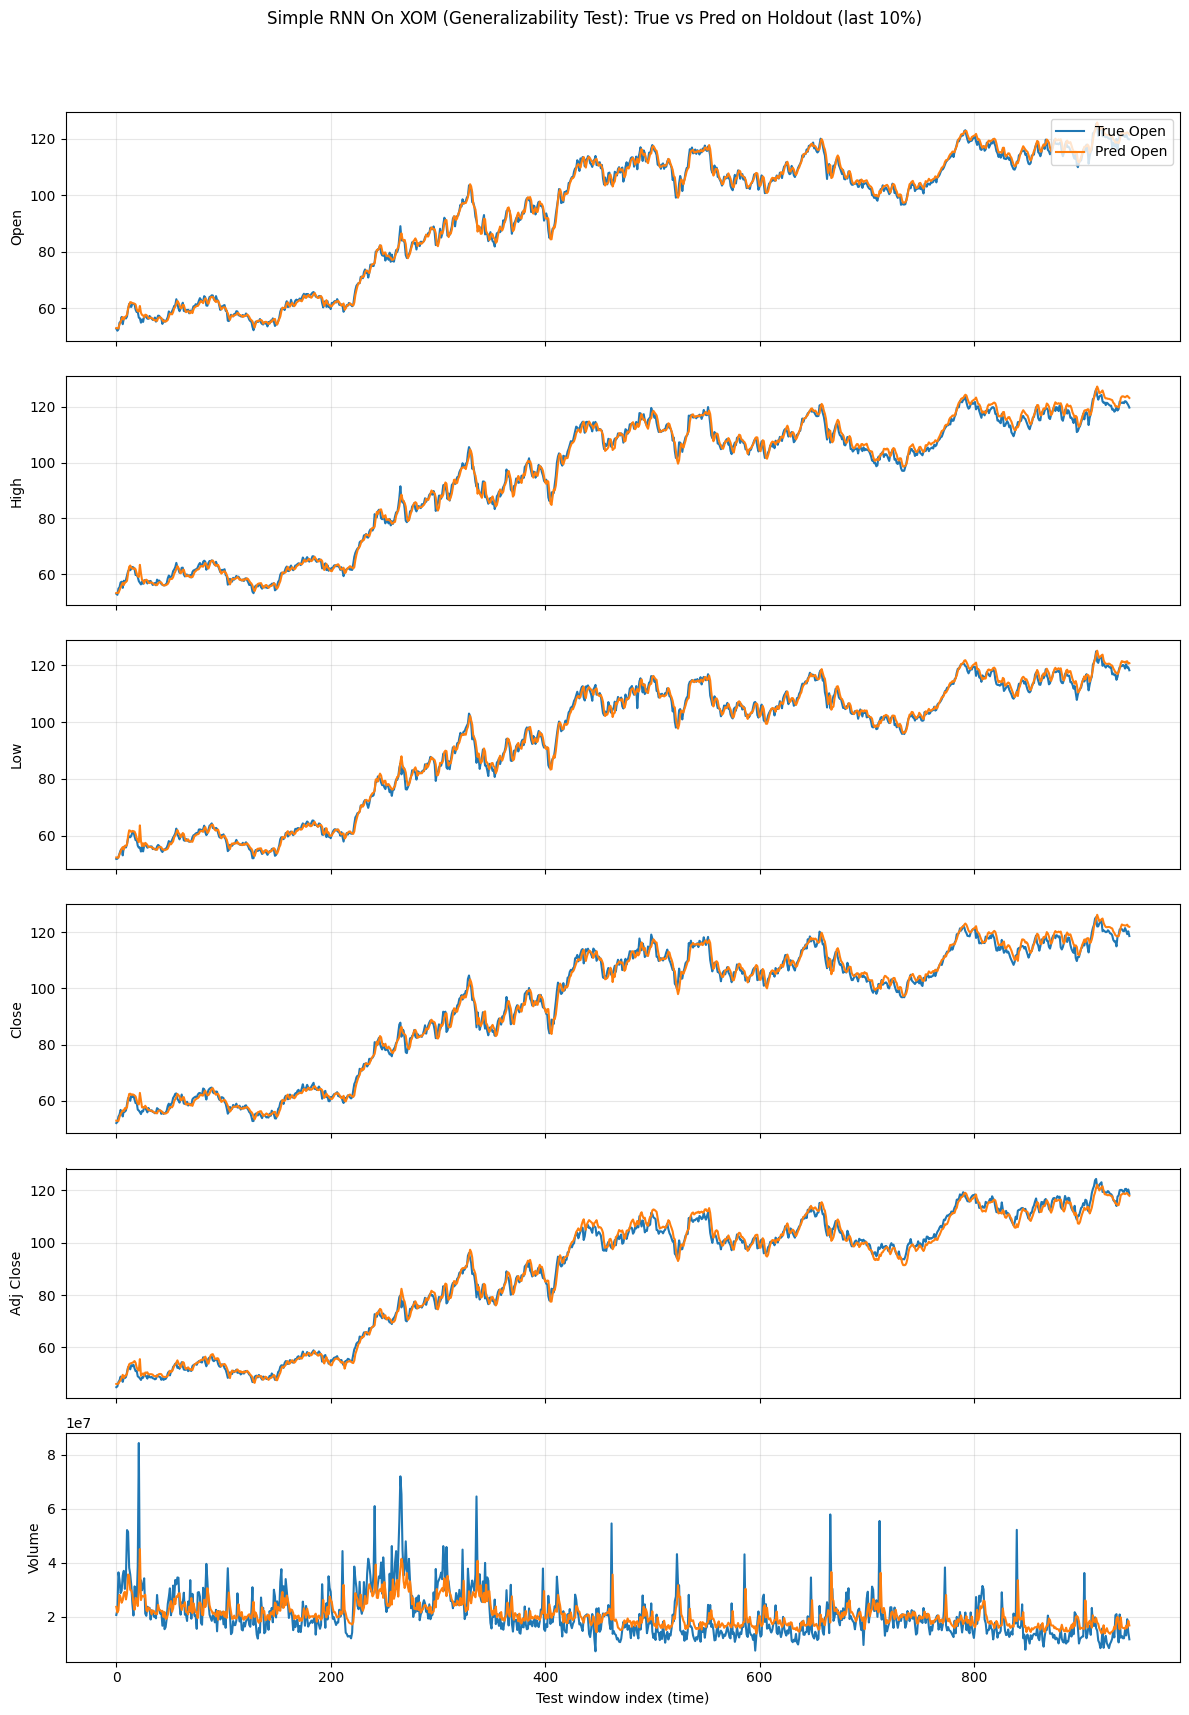

In [70]:
y_true_gen = scaler.inverse_transform(y_true_scaled_gen)
y_pred_gen = scaler.inverse_transform(y_pred_scaled_gen)

n_test = y_true_gen.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true_gen[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred_gen[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name} On XOM (Generalizability Test): True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**DEEP RNN**

In [72]:
model_name = "Deep RNN"
model = train_model(model_name)


[Deep RNN] Epoch 1/30, Train MSE (scaled): 0.5095
[Deep RNN] Epoch 5/30, Train MSE (scaled): 0.1783
[Deep RNN] Epoch 10/30, Train MSE (scaled): 0.1474
[Deep RNN] Epoch 15/30, Train MSE (scaled): 0.1429
[Deep RNN] Epoch 20/30, Train MSE (scaled): 0.1358
[Deep RNN] Epoch 25/30, Train MSE (scaled): 0.1350
[Deep RNN] Epoch 30/30, Train MSE (scaled): 0.1353


In [73]:
model.eval()
all_preds_scaled = []
all_true_scaled = []
all_last_inputs_scaled = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model(xb)

        all_preds_scaled.append(preds.cpu().numpy())
        all_true_scaled.append(yb.cpu().numpy())
        all_last_inputs_scaled.append(xb[:, -1, :].cpu().numpy())

In [74]:
y_pred_scaled = np.concatenate(all_preds_scaled, axis=0)
y_true_scaled = np.concatenate(all_true_scaled, axis=0)
X_last_scaled = np.concatenate(all_last_inputs_scaled, axis=0)

In [75]:
metrics = compute_metrics(y_true_scaled, y_pred_scaled, X_last_scaled)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Deep RNN ===
Scaled_RMSE : 0.4218330681324005
MAPE_percent : 8.868524551391602
MDA : 0.5340136289596558
R2 : 0.7924324870109558
Bias_overall : 141327.703125
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: 1.1002
  High: 0.7925
  Low: 0.6920
  Close: 0.6316
  Adj Close: -1.2899
  Volume: 847964.2500


In [76]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Deep RNN', 'Scaled RMSE': 0.4218330681324005, 'MAPE': 8.868524551391602, 'Mean Directional Accuracy (MDA)': 0.5340136289596558, 'R^2': 0.7924324870109558, 'Forecast Bias?': 'Over-forecast (too high)'}


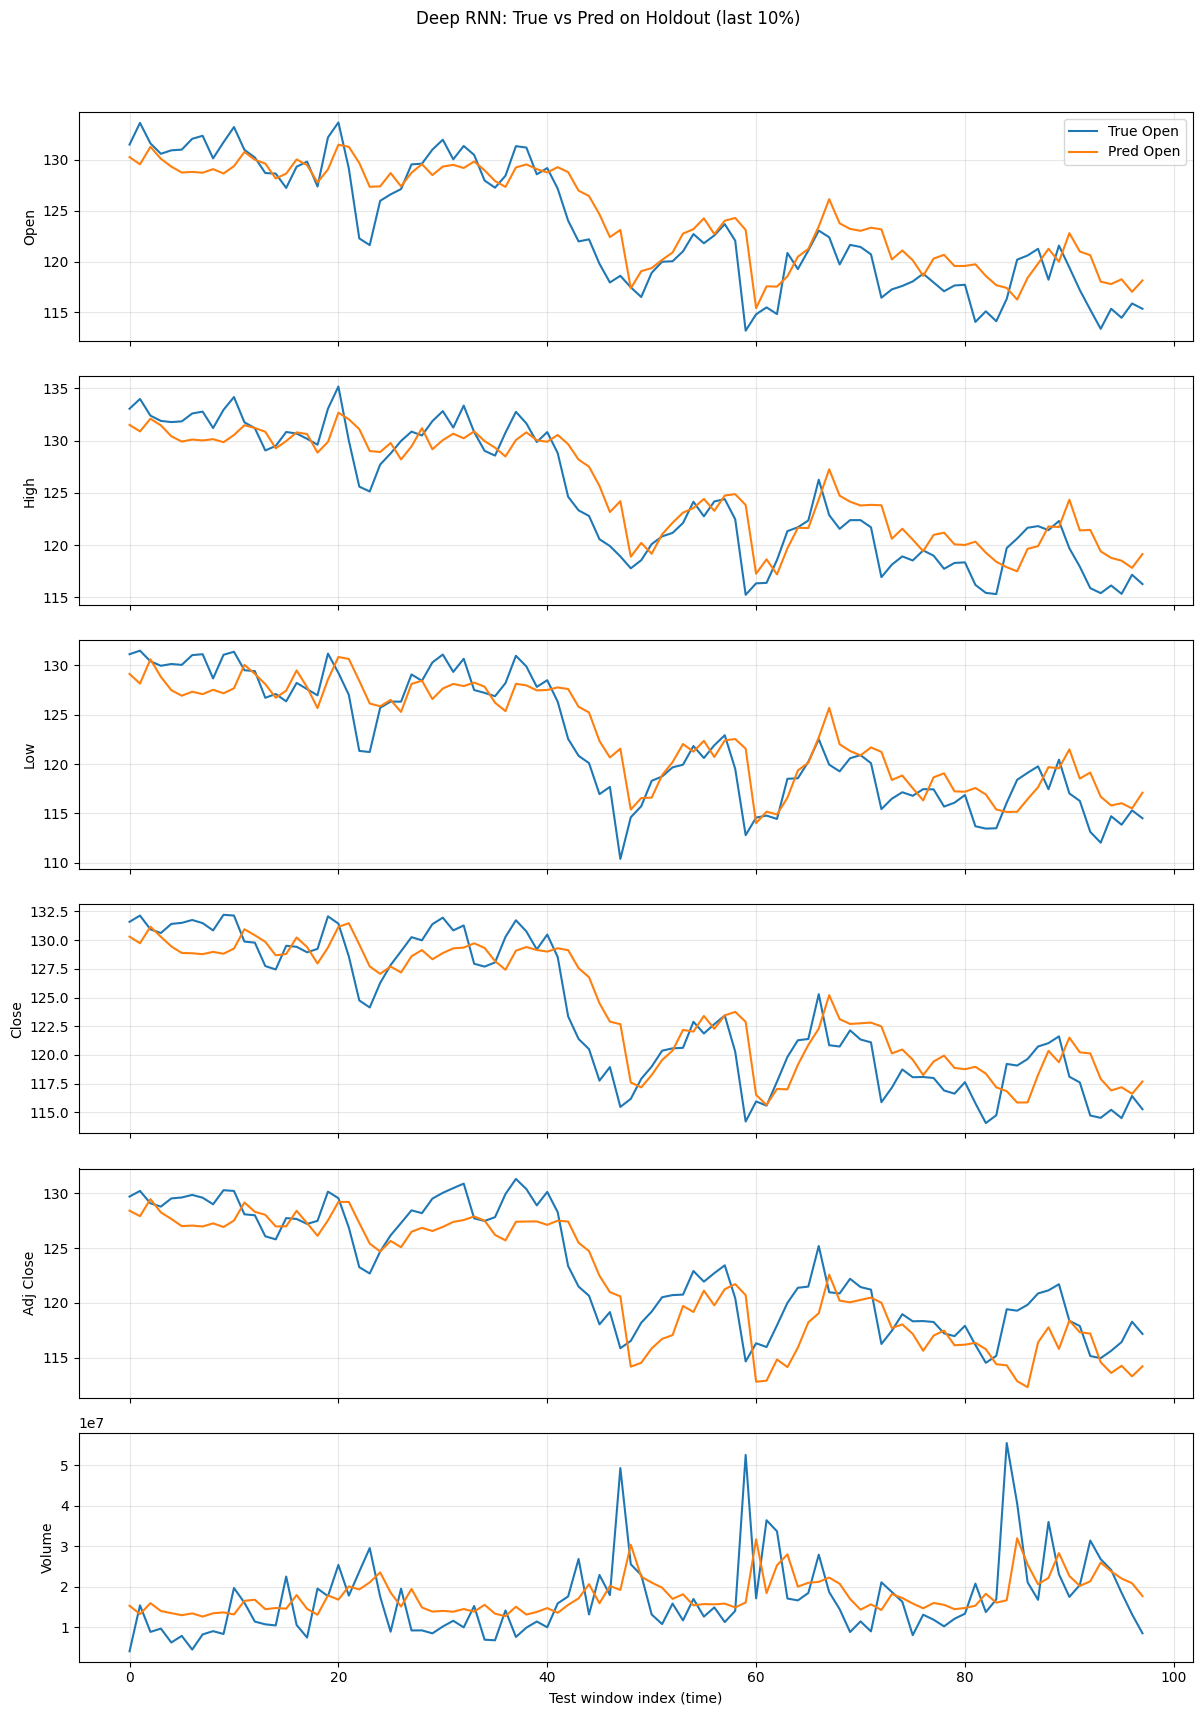

In [77]:
y_true = scaler.inverse_transform(y_true_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

n_test = y_true.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name}: True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Generalizability Test

In [78]:
model.eval()
all_preds_scaled_gen = []
all_true_scaled_gen = []
all_last_inputs_scaled_gen = []

with torch.no_grad():
    for xb, yb in test_loader_gen:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds_gen = model(xb)

        all_preds_scaled_gen.append(preds_gen.cpu().numpy())
        all_true_scaled_gen.append(yb.cpu().numpy())
        all_last_inputs_scaled_gen.append(xb[:, -1, :].cpu().numpy())

In [79]:
y_pred_scaled_gen = np.concatenate(all_preds_scaled_gen, axis=0) ## [N_test, D]
y_true_scaled_gen = np.concatenate(all_true_scaled_gen, axis=0) ## [N_test, D]
X_last_scaled_gen = np.concatenate(all_last_inputs_scaled_gen, axis=0) ## [N_test, D]

In [80]:
metrics = compute_metrics(y_true_scaled_gen, y_pred_scaled_gen, X_last_scaled_gen)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Deep RNN ===
Scaled_RMSE : 0.3165331482887268
MAPE_percent : 5.304206371307373
MDA : 0.5692389011383057
R2 : 0.8962416648864746
Bias_overall : 113294.5078125
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: 0.0905
  High: -0.1226
  Low: -0.1350
  Close: -0.2342
  Adj Close: -0.0533
  Volume: 679767.5000


In [81]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Deep RNN', 'Scaled RMSE': 0.3165331482887268, 'MAPE': 5.304206371307373, 'Mean Directional Accuracy (MDA)': 0.5692389011383057, 'R^2': 0.8962416648864746, 'Forecast Bias?': 'Over-forecast (too high)'}


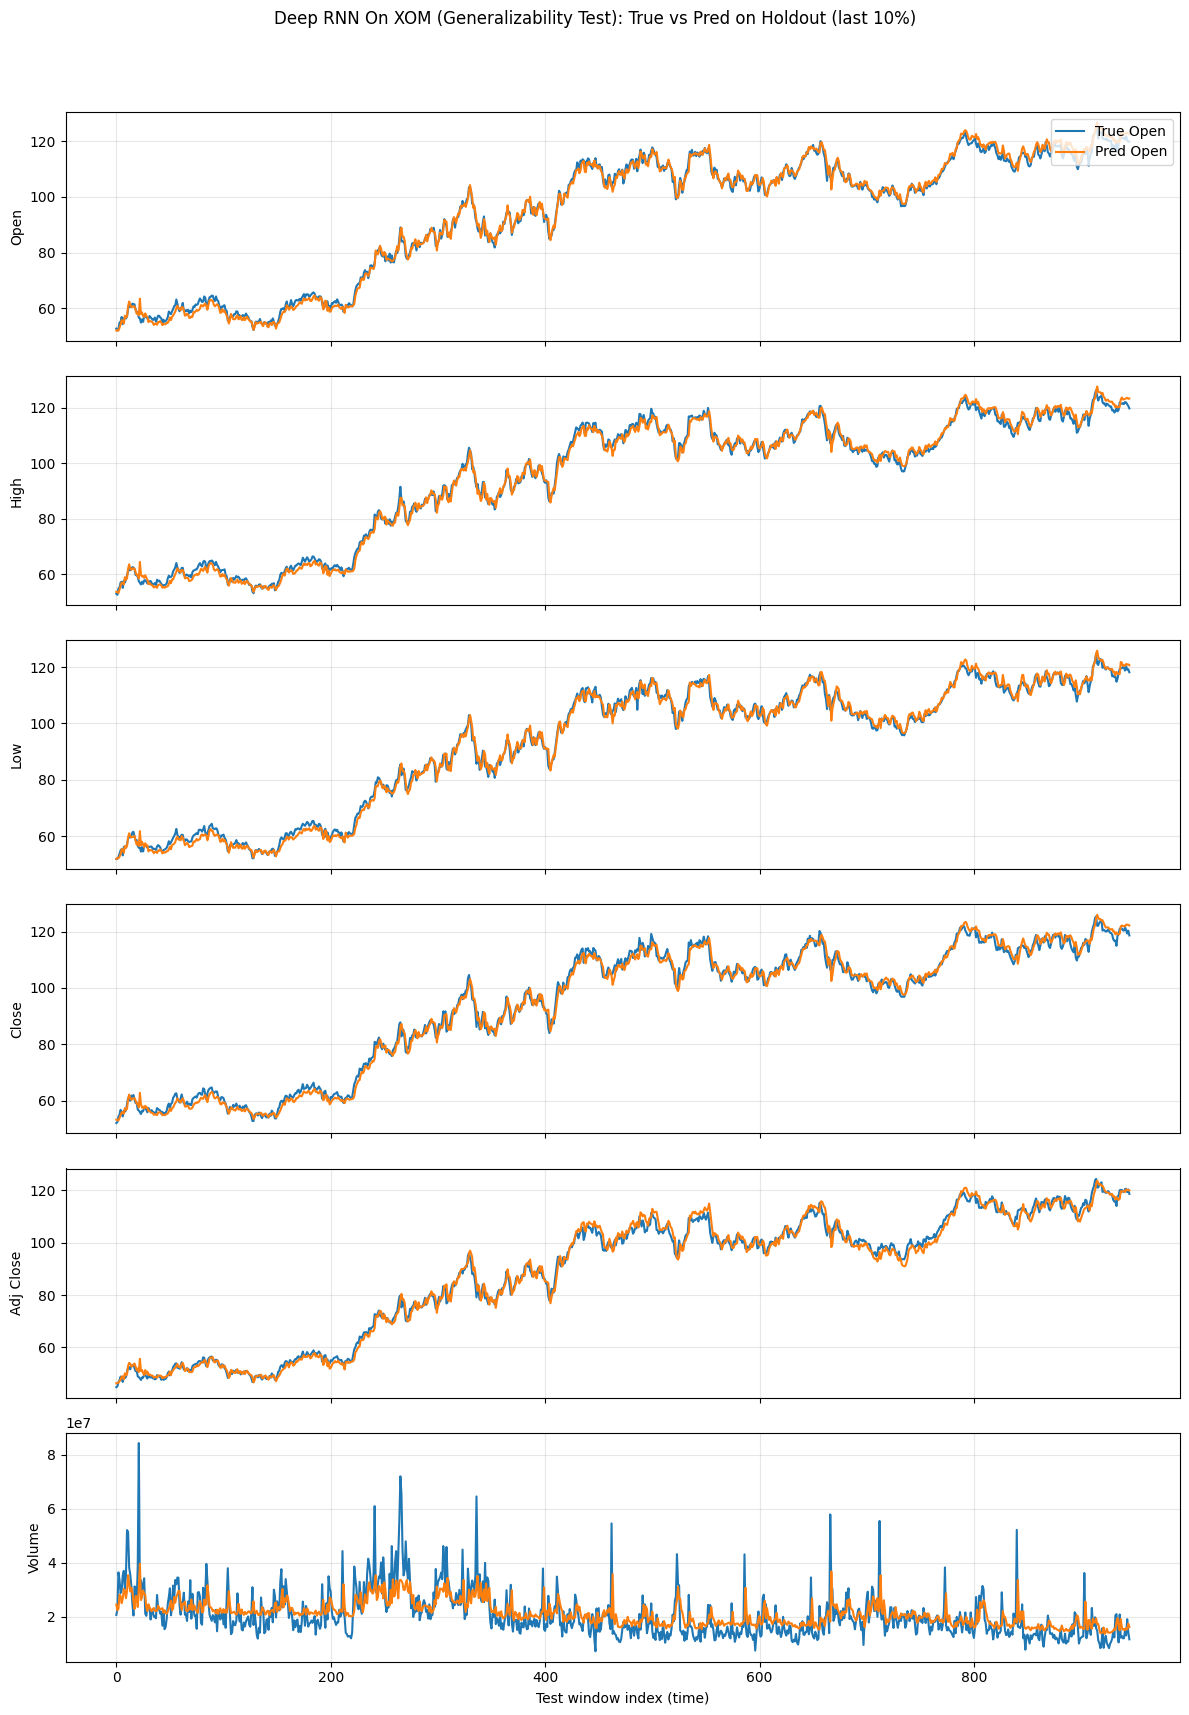

In [82]:
y_true_gen = scaler.inverse_transform(y_true_scaled_gen)
y_pred_gen = scaler.inverse_transform(y_pred_scaled_gen)

n_test = y_true_gen.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true_gen[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred_gen[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name} On XOM (Generalizability Test): True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**SIMPLE GRU**

In [84]:
model_name = "Simple GRU"
model = train_model(model_name)


[Simple GRU] Epoch 1/30, Train MSE (scaled): 0.8447
[Simple GRU] Epoch 5/30, Train MSE (scaled): 0.1660
[Simple GRU] Epoch 10/30, Train MSE (scaled): 0.1452
[Simple GRU] Epoch 15/30, Train MSE (scaled): 0.1403
[Simple GRU] Epoch 20/30, Train MSE (scaled): 0.1381
[Simple GRU] Epoch 25/30, Train MSE (scaled): 0.1372
[Simple GRU] Epoch 30/30, Train MSE (scaled): 0.1364


In [85]:
model.eval()
all_preds_scaled = []
all_true_scaled = []
all_last_inputs_scaled = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model(xb)

        all_preds_scaled.append(preds.cpu().numpy())
        all_true_scaled.append(yb.cpu().numpy())
        all_last_inputs_scaled.append(xb[:, -1, :].cpu().numpy())

In [86]:
y_pred_scaled = np.concatenate(all_preds_scaled, axis=0)
y_true_scaled = np.concatenate(all_true_scaled, axis=0)
X_last_scaled = np.concatenate(all_last_inputs_scaled, axis=0)

In [87]:
metrics = compute_metrics(y_true_scaled, y_pred_scaled, X_last_scaled)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Simple GRU ===
Scaled_RMSE : 0.4207533597946167
MAPE_percent : 8.815597534179688
MDA : 0.5153061151504517
R2 : 0.7934936881065369
Bias_overall : 152658.0625
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: 1.1093
  High: 0.6962
  Low: 0.9684
  Close: 0.9487
  Adj Close: -1.2290
  Volume: 915945.8750


In [88]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Simple GRU', 'Scaled RMSE': 0.4207533597946167, 'MAPE': 8.815597534179688, 'Mean Directional Accuracy (MDA)': 0.5153061151504517, 'R^2': 0.7934936881065369, 'Forecast Bias?': 'Over-forecast (too high)'}


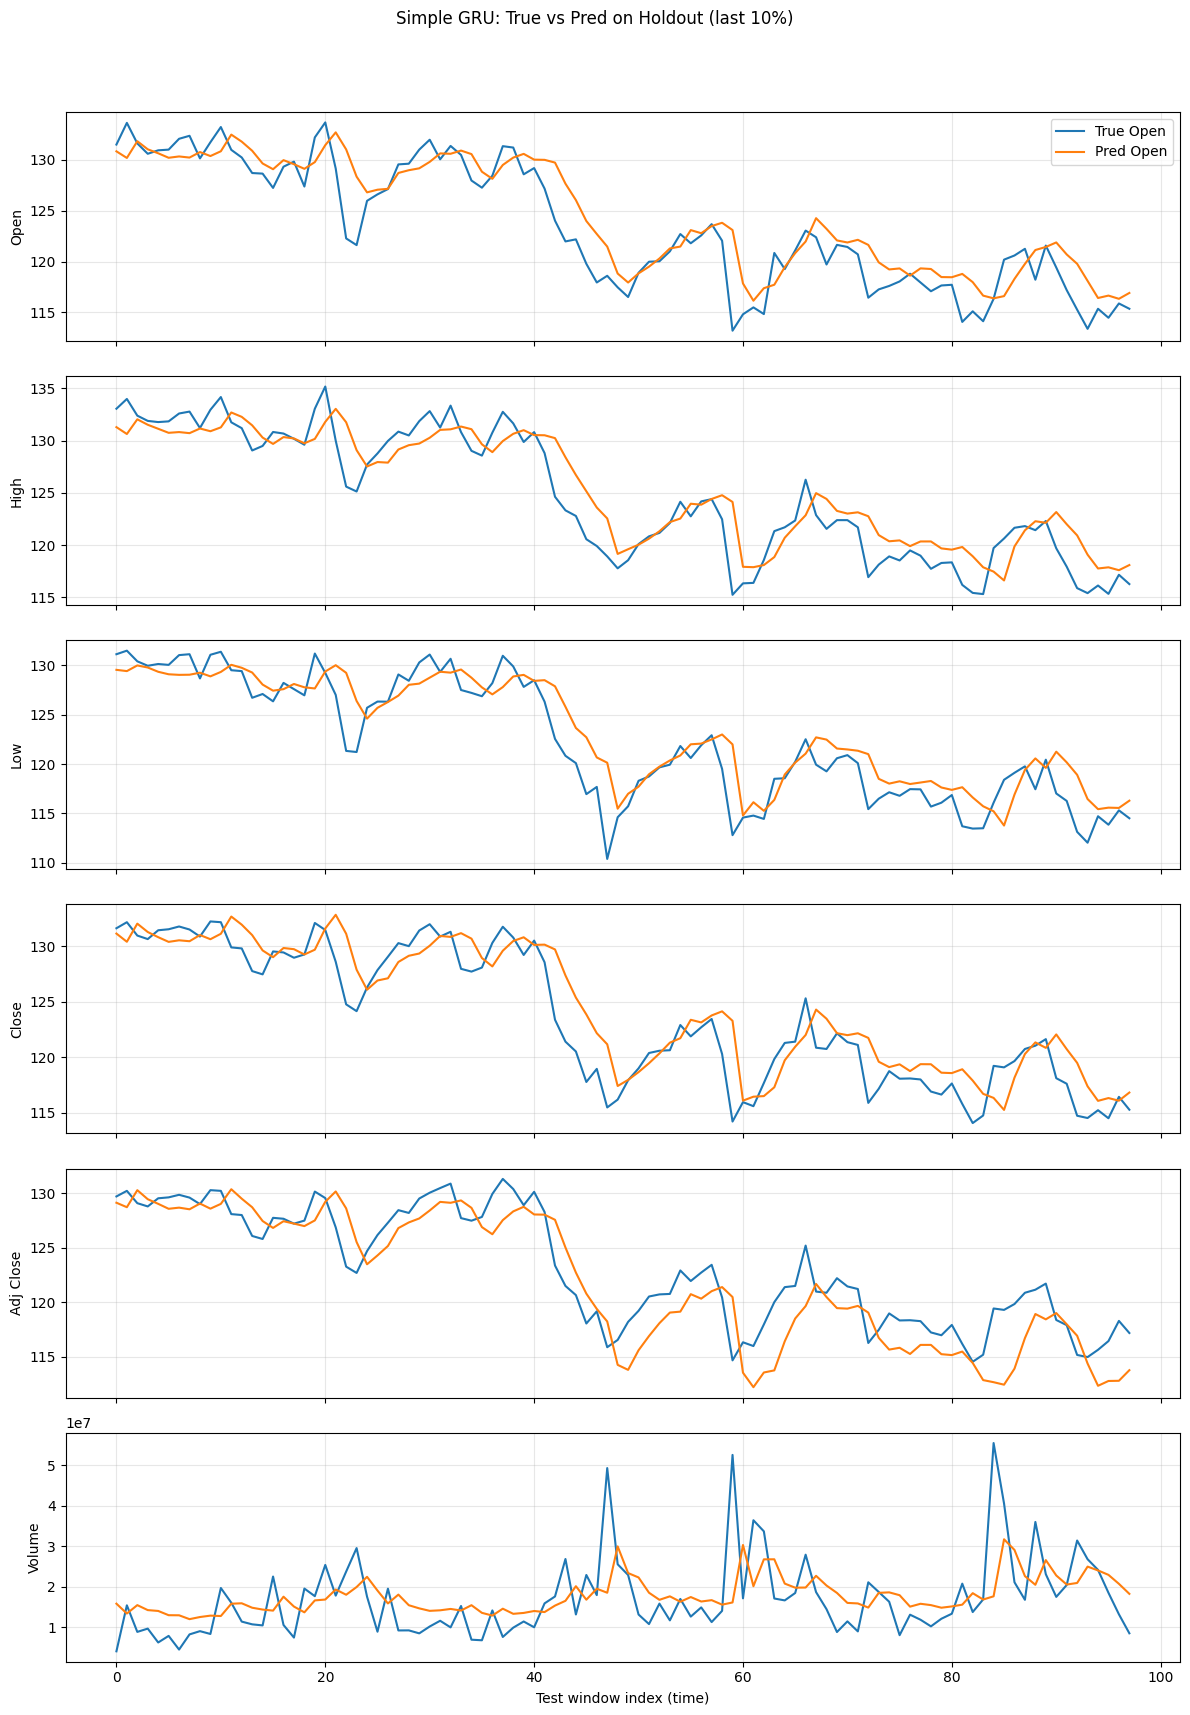

In [89]:
y_true = scaler.inverse_transform(y_true_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

n_test = y_true.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name}: True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Generalizability Test

In [90]:
model.eval()
all_preds_scaled_gen = []
all_true_scaled_gen = []
all_last_inputs_scaled_gen = []

with torch.no_grad():
    for xb, yb in test_loader_gen:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds_gen = model(xb)

        all_preds_scaled_gen.append(preds_gen.cpu().numpy())
        all_true_scaled_gen.append(yb.cpu().numpy())
        all_last_inputs_scaled_gen.append(xb[:, -1, :].cpu().numpy())

In [91]:
y_pred_scaled_gen = np.concatenate(all_preds_scaled_gen, axis=0) ## [N_test, D]
y_true_scaled_gen = np.concatenate(all_true_scaled_gen, axis=0) ## [N_test, D]
X_last_scaled_gen = np.concatenate(all_last_inputs_scaled_gen, axis=0) ## [N_test, D]

In [92]:
metrics = compute_metrics(y_true_scaled_gen, y_pred_scaled_gen, X_last_scaled_gen)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Simple GRU ===
Scaled_RMSE : 0.313728392124176
MAPE_percent : 5.187967300415039
MDA : 0.5505637526512146
R2 : 0.8980723023414612
Bias_overall : 77676.7421875
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: 0.1456
  High: 0.1887
  Low: 0.3220
  Close: 0.3199
  Adj Close: 0.1553
  Volume: 466059.3125


In [93]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Simple GRU', 'Scaled RMSE': 0.313728392124176, 'MAPE': 5.187967300415039, 'Mean Directional Accuracy (MDA)': 0.5505637526512146, 'R^2': 0.8980723023414612, 'Forecast Bias?': 'Over-forecast (too high)'}


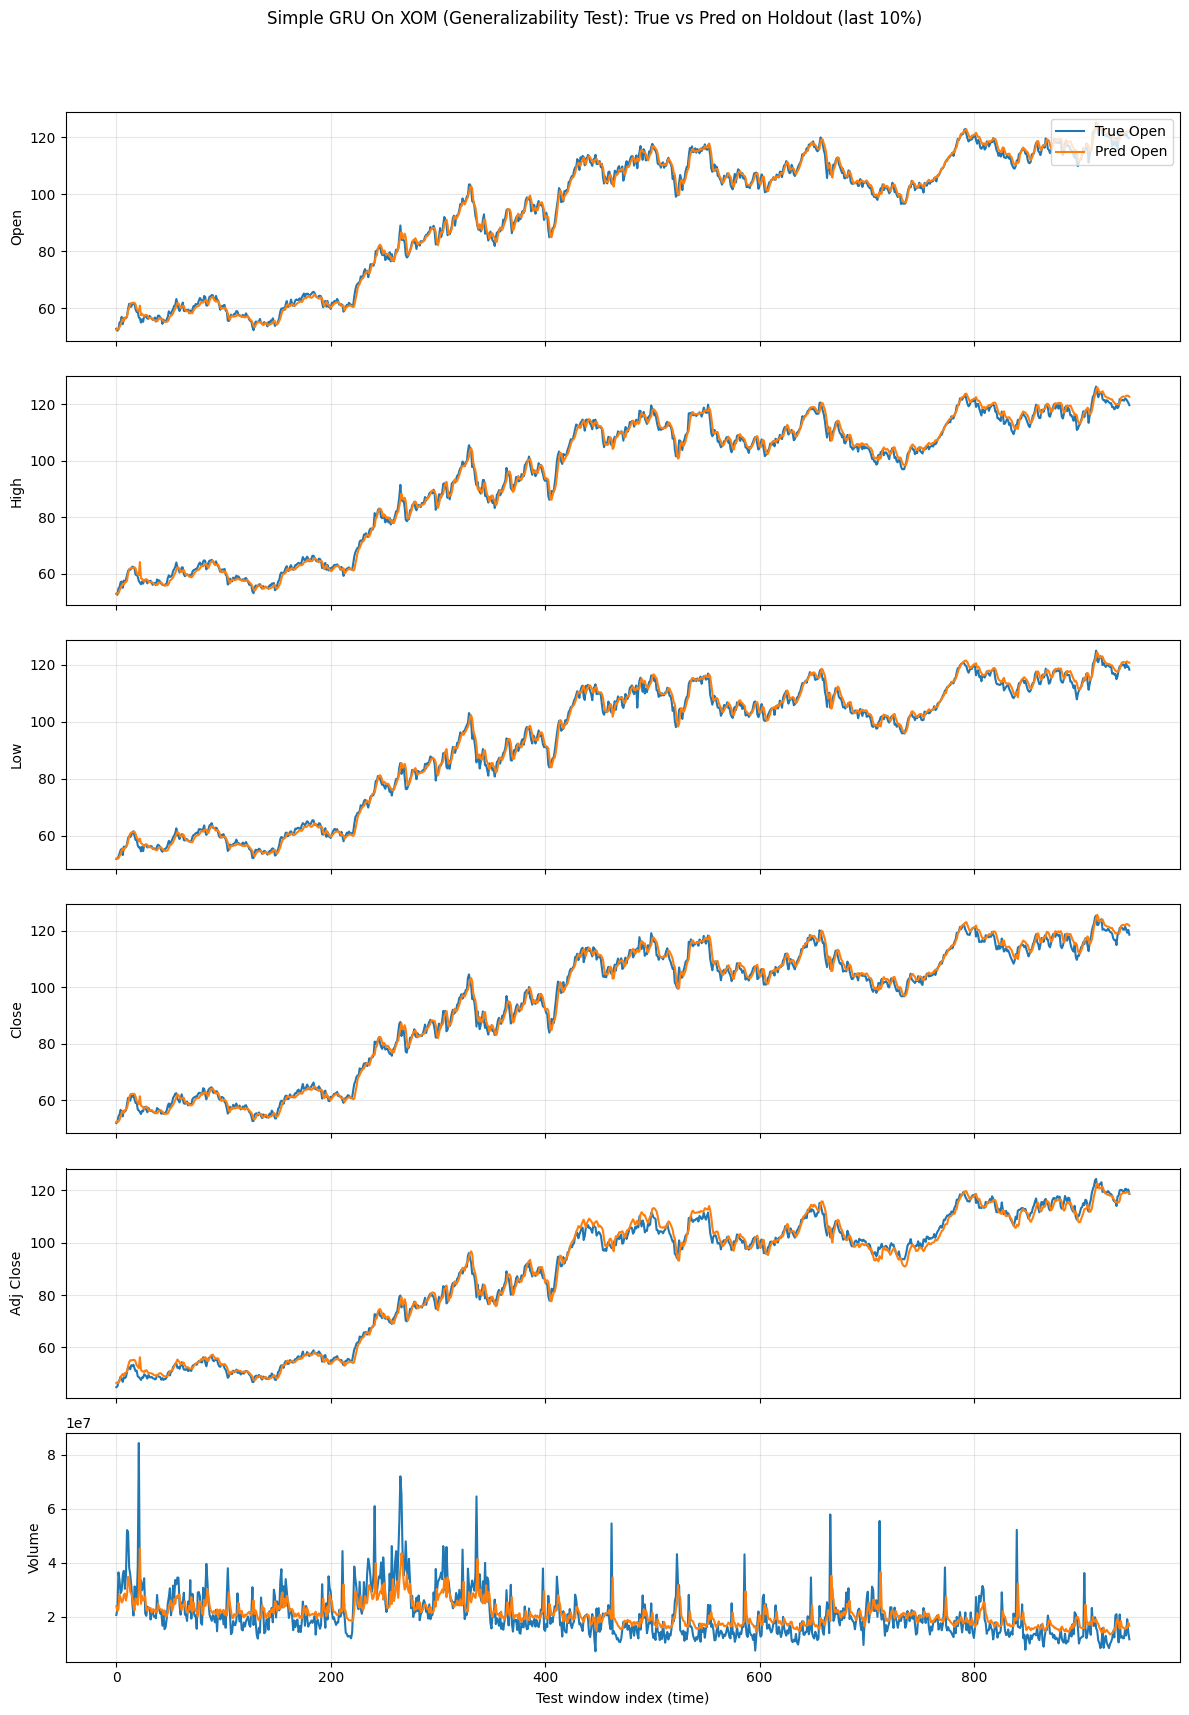

In [94]:
y_true_gen = scaler.inverse_transform(y_true_scaled_gen)
y_pred_gen = scaler.inverse_transform(y_pred_scaled_gen)

n_test = y_true_gen.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true_gen[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred_gen[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name} On XOM (Generalizability Test): True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**DEEP GRU**

In [95]:
model_name = "Deep GRU"
model = train_model(model_name)


[Deep GRU] Epoch 1/30, Train MSE (scaled): 0.6690
[Deep GRU] Epoch 5/30, Train MSE (scaled): 0.1761
[Deep GRU] Epoch 10/30, Train MSE (scaled): 0.1490
[Deep GRU] Epoch 15/30, Train MSE (scaled): 0.1388
[Deep GRU] Epoch 20/30, Train MSE (scaled): 0.1374
[Deep GRU] Epoch 25/30, Train MSE (scaled): 0.1358
[Deep GRU] Epoch 30/30, Train MSE (scaled): 0.1350


In [96]:
model.eval()
all_preds_scaled = []
all_true_scaled = []
all_last_inputs_scaled = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model(xb)

        all_preds_scaled.append(preds.cpu().numpy())
        all_true_scaled.append(yb.cpu().numpy())
        all_last_inputs_scaled.append(xb[:, -1, :].cpu().numpy())

In [97]:
y_pred_scaled = np.concatenate(all_preds_scaled, axis=0)
y_true_scaled = np.concatenate(all_true_scaled, axis=0)
X_last_scaled = np.concatenate(all_last_inputs_scaled, axis=0)

In [98]:
metrics = compute_metrics(y_true_scaled, y_pred_scaled, X_last_scaled)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Deep GRU ===
Scaled_RMSE : 0.41753244400024414
MAPE_percent : 8.374516487121582
MDA : 0.5612244606018066
R2 : 0.7966432571411133
Bias_overall : 77830.6484375
Bias_flag : Over-forecast (too high)
Bias_per_feature :
  Open: 0.7935
  High: 0.2853
  Low: 0.4888
  Close: 0.4055
  Adj Close: -1.4484
  Volume: 466983.3438


In [99]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Deep GRU', 'Scaled RMSE': 0.41753244400024414, 'MAPE': 8.374516487121582, 'Mean Directional Accuracy (MDA)': 0.5612244606018066, 'R^2': 0.7966432571411133, 'Forecast Bias?': 'Over-forecast (too high)'}


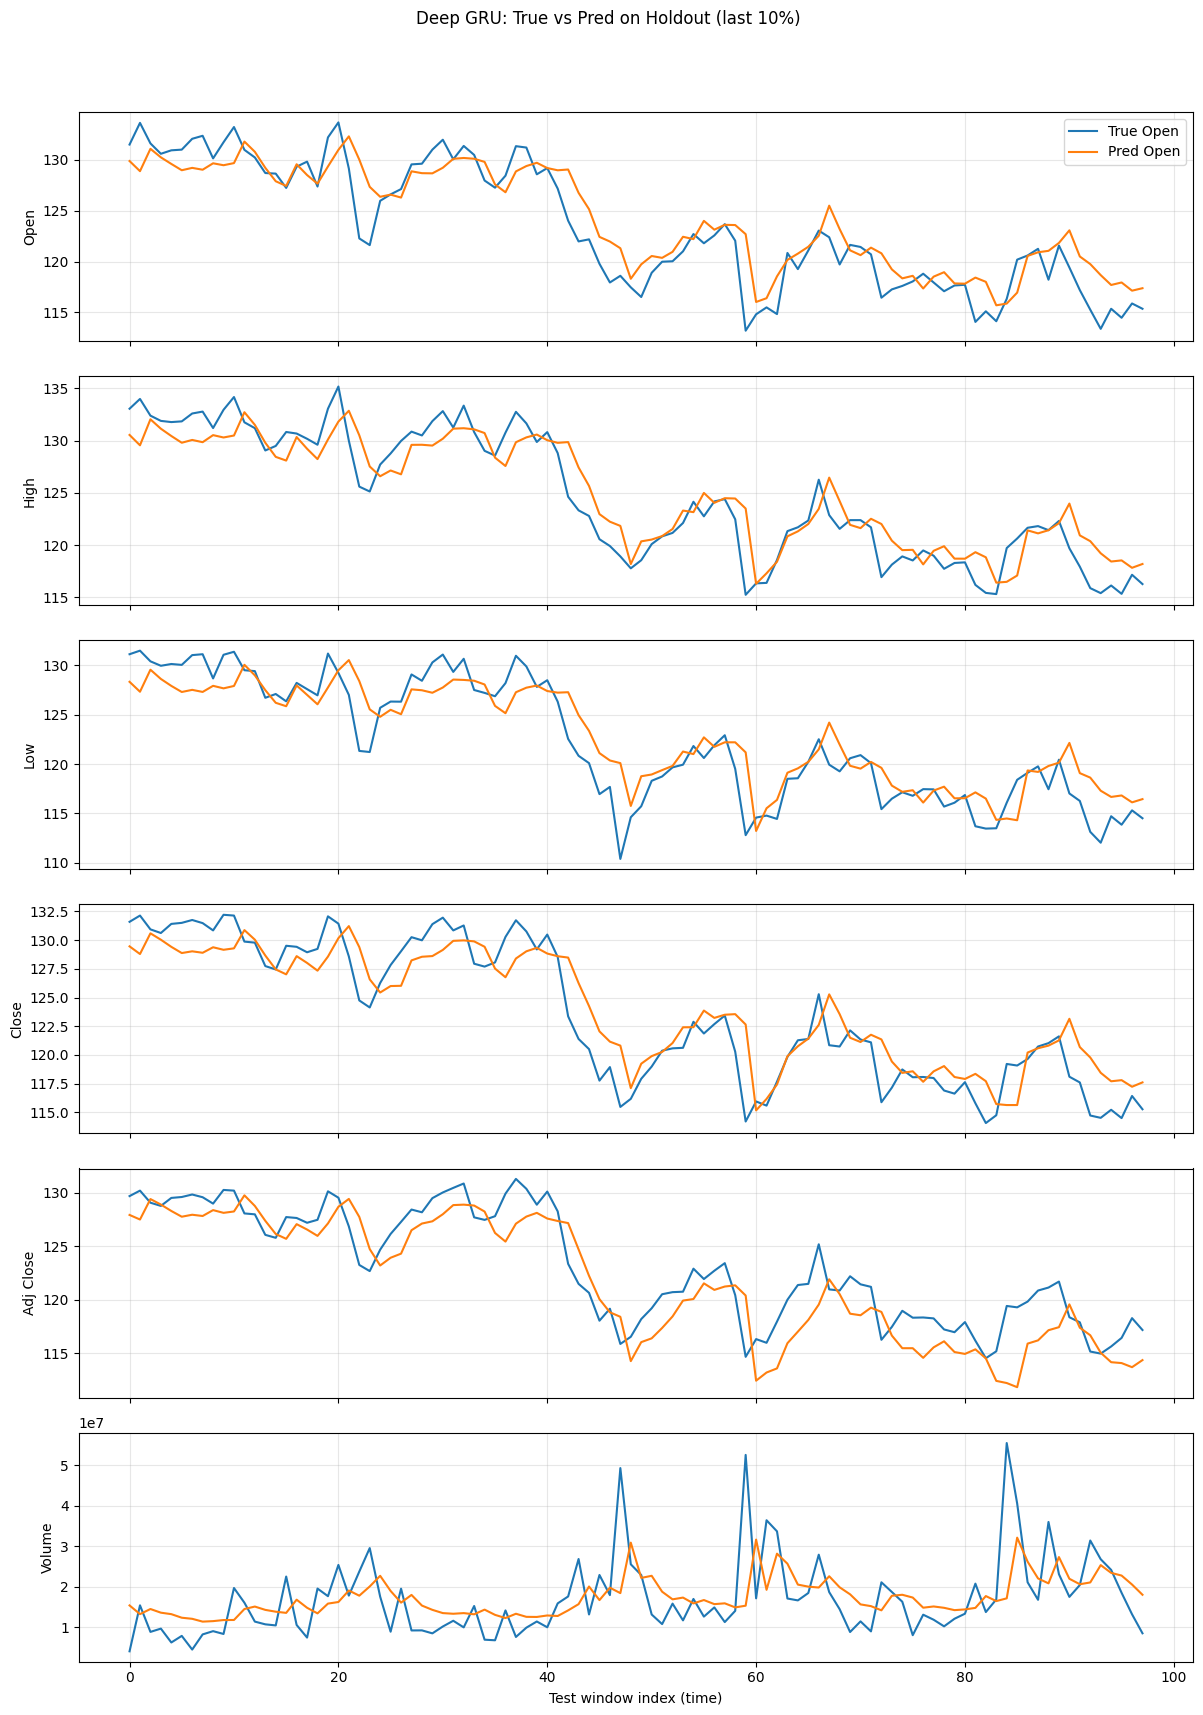

In [100]:
y_true = scaler.inverse_transform(y_true_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)

n_test = y_true.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name}: True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Generalizability Test

In [101]:
model.eval()
all_preds_scaled_gen = []
all_true_scaled_gen = []
all_last_inputs_scaled_gen = []

with torch.no_grad():
    for xb, yb in test_loader_gen:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds_gen = model(xb)

        all_preds_scaled_gen.append(preds_gen.cpu().numpy())
        all_true_scaled_gen.append(yb.cpu().numpy())
        all_last_inputs_scaled_gen.append(xb[:, -1, :].cpu().numpy())

In [102]:
y_pred_scaled_gen = np.concatenate(all_preds_scaled_gen, axis=0) ## [N_test, D]
y_true_scaled_gen = np.concatenate(all_true_scaled_gen, axis=0) ## [N_test, D]
X_last_scaled_gen = np.concatenate(all_last_inputs_scaled_gen, axis=0) ## [N_test, D]

In [103]:
metrics = compute_metrics(y_true_scaled_gen, y_pred_scaled_gen, X_last_scaled_gen)
print("\n=== Metrics for", model_name, "===")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(k, ":")
        for kk, vv in v.items():
            print(f"  {kk}: {vv:.4f}")
    else:
        print(k, ":", v)


=== Metrics for Deep GRU ===
Scaled_RMSE : 0.31579598784446716
MAPE_percent : 4.9682745933532715
MDA : 0.5662438273429871
R2 : 0.8967244029045105
Bias_overall : 2147.984130859375
Bias_flag : None / minimal
Bias_per_feature :
  Open: 0.0480
  High: -0.0685
  Low: 0.0969
  Close: 0.1261
  Adj Close: -0.0958
  Volume: 12887.7988


In [104]:
row_for_sheet = {
    "Model": model_name,
    "Scaled RMSE": metrics["Scaled_RMSE"],
    "MAPE": metrics["MAPE_percent"],
    "Mean Directional Accuracy (MDA)": metrics["MDA"],
    "R^2": metrics["R2"],
    "Forecast Bias?": metrics["Bias_flag"],
}
print("\nRow for spreadsheet:", row_for_sheet)


Row for spreadsheet: {'Model': 'Deep GRU', 'Scaled RMSE': 0.31579598784446716, 'MAPE': 4.9682745933532715, 'Mean Directional Accuracy (MDA)': 0.5662438273429871, 'R^2': 0.8967244029045105, 'Forecast Bias?': 'None / minimal'}


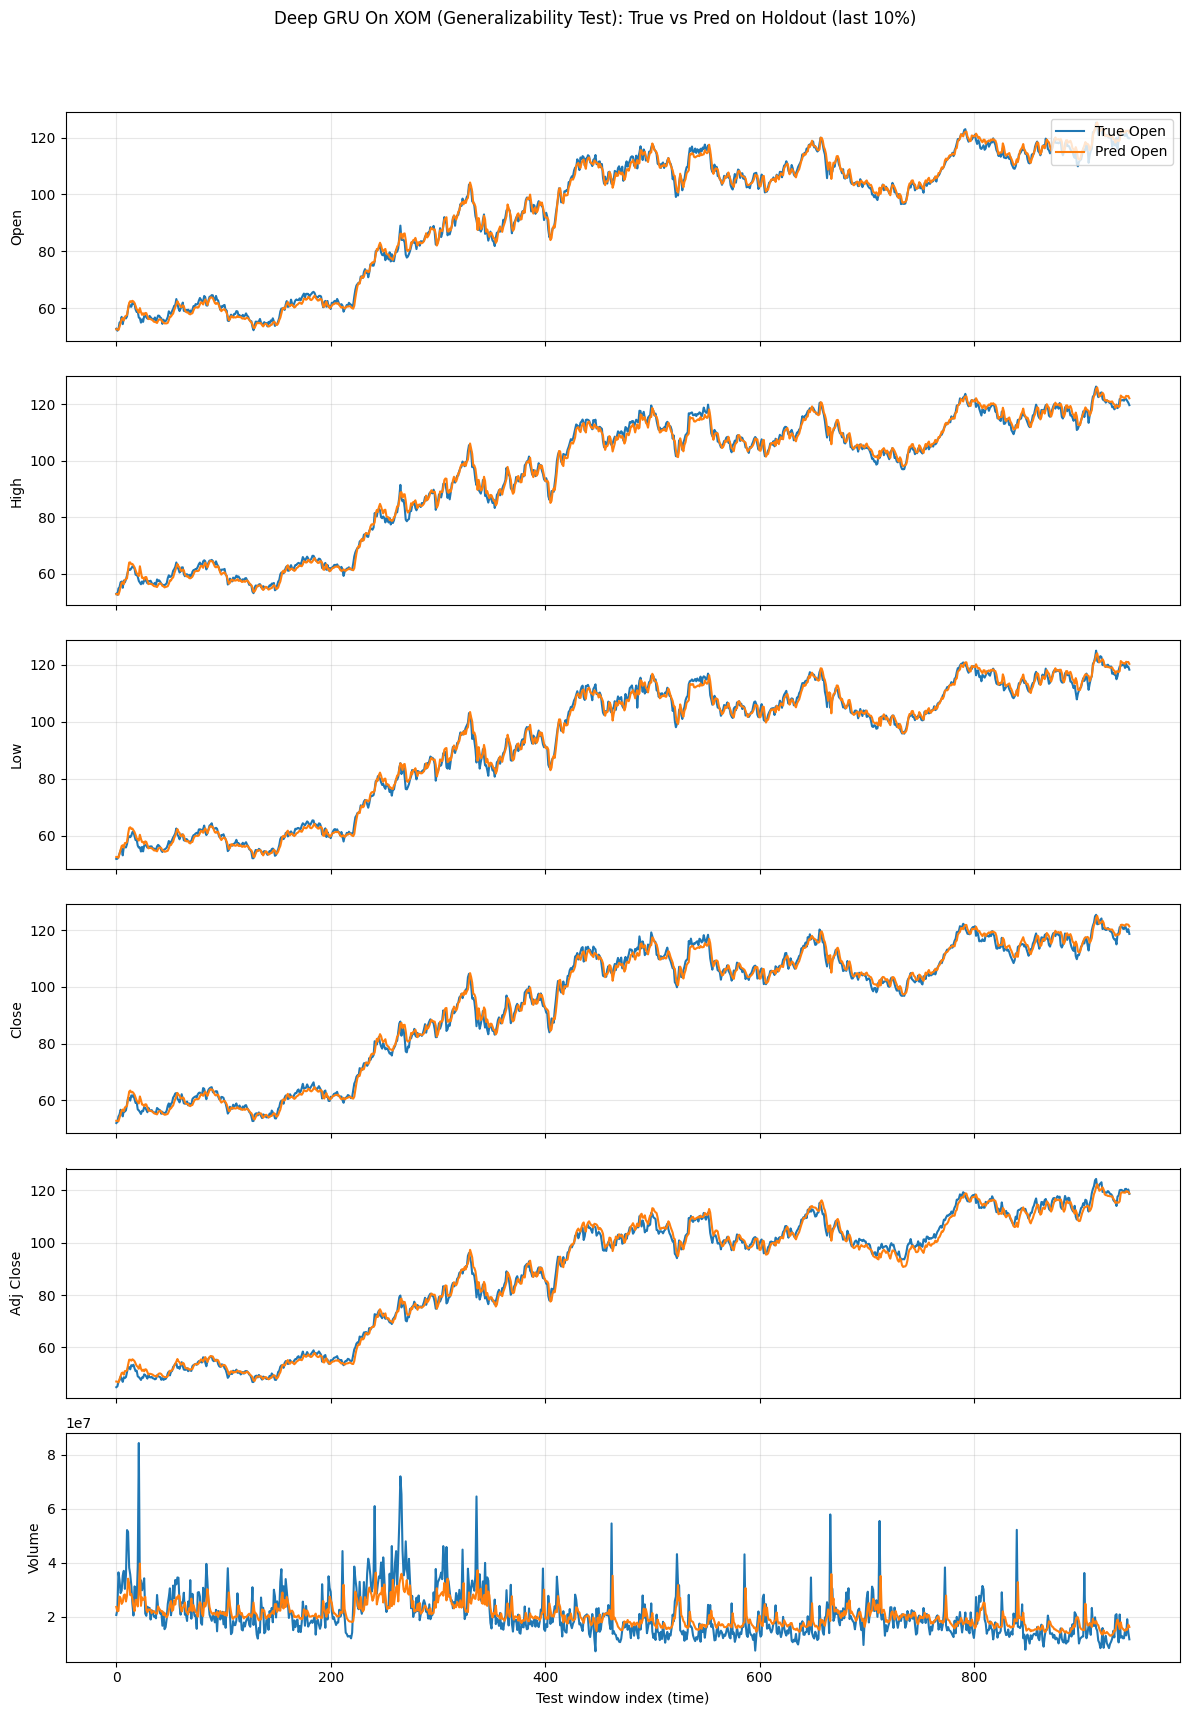

: 

In [105]:
y_true_gen = scaler.inverse_transform(y_true_scaled_gen)
y_pred_gen = scaler.inverse_transform(y_pred_scaled_gen)

n_test = y_true_gen.shape[0]
t_axis = np.arange(n_test)

fig, axes = plt.subplots(n_features, 1,
                         figsize=(12, 3 * n_features),
                         sharex=True)

if n_features == 1:
    axes = [axes]

for d, col in enumerate(feature_cols):
    ax = axes[d]
    ax.plot(t_axis, y_true_gen[:, d], label=f"True {col}")
    ax.plot(t_axis, y_pred_gen[:, d], label=f"Pred {col}")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    if d == 0:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Test window index (time)")
plt.suptitle(f"{model_name} On XOM (Generalizability Test): True vs Pred on Holdout (last 10%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()